In [1]:
import statistics
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

import pyxdf
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats


import os

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

from tqdm import tqdm_notebook

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate 

In [2]:
# Функции для выгрузки файлов и создание нормального raw формата для использования mne

%matplotlib

def show_streams(content):
    streams_names = [i['info']['name'][0] for i in content]
    print(f'Available streams: {streams_names}')
    
def get_stream(name, content):
    streams_names = [i['info']['name'][0] for i in content]
    if name not in streams_names:
        raise NameError(f'Stream {name} is not in the list.\nAvailable streams: {streams_names}')
    sdata = content[streams_names.index(name)]

    data = sdata['time_series']
    ts = sdata['time_stamps']

    print('Reading stream: ', sdata['info']['name'][0])
    print(f'Recording duration: {ts[-1] - ts[0]} sec')
    print('Effective sampling rate: ', data.shape[0] / (ts[-1] - ts[0]), '\n')
    global freq_1
    freq_1=data.shape[0] / (ts[-1] - ts[0])
    print('Data shape:', data.shape)
    return {'data': data,
            'ts': ts,
            'info':{k:v for k,v in sdata['info'].items() if k != 'desc'},
            'channels': [i['label'][0] for i in sdata['info']['desc'][0]['channels'][0]['channel']]
            }
def get_stream_events(name, content):
    streams_names = [i['info']['name'][0] for i in content]
    if name not in streams_names:
        raise NameError(f'Stream {name} is not in the list.\nAvailable streams: {streams_names}')
    sdata = content[streams_names.index(name)]

    data = sdata['time_series']
    ts = sdata['time_stamps']

    print('Reading stream: ', sdata['info']['name'][0])
    print(f'Recording duration: {ts[-1] - ts[0]} sec')
    print('Effective sampling rate: ', data.shape[0] / (ts[-1] - ts[0]), '\n')
    #global freq_2
    #freq_2=data.shape[0] / (ts[-1] - ts[0])
    print('Data shape:', data.shape)
    return {'data': data,
            'ts': ts,
            'info':{k:v for k,v in sdata['info'].items() if k != 'desc'},
            }

def makeMontage(raw):
    raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})
    #Нарисуем 2д наш монтаж
    # Form the 10-20 montage
    mont1020 = mne.channels.make_standard_montage('standard_1020')
    # Choose what channels you want to keep 
    # Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
    kept_channels = ['F3', 'F4', 'T3', 'T4', 'O1', 'O2']
    ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
    mont1020_new = mont1020.copy()
    # Keep only the desired channels
    mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
    kept_channel_info = [mont1020.dig[x+3] for x in ind]
    # Keep the first three rows as they are the fiducial points information
    mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
    #mont1020_new.plot()
    raw.set_montage(mont1020_new)
    
#выгружаем ээг с событиями и ставим разные события для 1-back и 2-back
def fileLoad(xdffile):
    # Read xdf
    content, header = pyxdf.load_xdf(xdffile, synchronize_clocks=True, dejitter_timestamps=False)
    show_streams(content)
    # Load streams separately 
    eeg = get_stream('Cortex-lsl-data-sream', content)
    events = get_stream_events('MyMarkerStream', content)
    print(freq_1)
    #freq_2)
    # Access data 
    eeg_data = eeg['data'] # numpy array (samples, n_channels)
    #Reduce amplitude
    eeg_data = eeg['data'] / 1000000
    eeg_ts = eeg['ts'] # timestamps are already synchronized among the streams at these point
    events_data = events['data']
    events_ts=events['ts']
    info=mne.create_info(eeg['channels'],freq_1)
    data=np.transpose(eeg['data'])
    print('events and eeg ts: ', events_ts, eeg_ts)
    events_d = [0]
    # данные событий в т ч 0 начало записи
    for i in events_data:
        events_d.append(int(i))
    print('Events + 0 event',events_d,'количество события:', len(events_d))
    #находим индексы ивентов (соответсвующие индексам точек ээг)
    #т.е. temp это таймстемп
    temp_events,temp_eeg=events_ts.copy(),eeg_ts.copy()
    event_index=[0]
    for i in temp_events:
        for jr in range(len(temp_eeg)):
            if i - temp_eeg[jr] <= 0.1:
                event_index.append(jr)
                break
    #make events
    zerolist = [0 for _ in range(47)]
    events = []
    for i in range(27):
        events.append([event_index[i], zerolist[i], events_d[i]])
    for i in range(27, 47):
        events.append([event_index[i], zerolist[i], 6])
    events = np.array(events)
    info=mne.create_info(eeg['channels'],freq_1)
    data=np.transpose(eeg_data)
    raw=mne.io.RawArray(data,info)
    #raw.plot(events=events)
    raw.pick(['all']).load_data()
    makeMontage(raw)
    return(raw, events)
    #print(event_index)
#plot
#raw=mne.io.RawArray(data,info)
#raw.plot()


Using matplotlib backend: <object object at 0x00000218D058C9E0>


In [3]:
#создадим словари с ЭЭГ и с событиями по всем людям
path_dir = "G:\\.shortcut-targets-by-id\\166Cp9_JW_szly6kshNpaIVJxZumVwx43\\Easy EEG\\Data\\SeptemberOctober\\neuroplay"

dir_list = os.listdir(path_dir)
#dir_list.remove('desktop.ini')
dir_list.remove('MedvedevaNeuroplay.xdf')

raw_list = {}
events_list = {}
names=[]
for i in dir_list:
    name = i[:5]
    names.append(name)
    raw, events = fileLoad(path_dir+'\\'+i)
    raw.pick(['all']).load_data()
    raw_list[name] = raw
    events_list[name] = events
    text = '\n'+ name + "succesful" + '\n'
    print(text)
raw_list

Available streams: ['MyMarkerStream', 'Cortex-lsl-data-sream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 296.989527249767 sec
Effective sampling rate:  124.86298875048664 

Data shape: (37083, 6)
Reading stream:  MyMarkerStream
Recording duration: 258.33537051605526 sec
Effective sampling rate:  0.17806311194672875 

Data shape: (46, 1)
124.86298875048664
events and eeg ts:  [396263.34958813 396268.15020479 396269.24969251 396329.2492721
 396332.78446325 396393.76624765 396398.64605112 396402.91585997
 396405.74051281 396408.47138475 396411.45041719 396414.79546573
 396417.81947687 396420.78372981 396423.51719785 396426.55793699
 396429.64262263 396432.73743487 396435.5514282  396438.41967494
 396441.25693698 396444.19970652 396447.04029896 396449.9771207
 396452.95066853 396455.70335807 396460.13849443 396464.41953009
 396468.71965444 396471.75098888 396474.80747472 396477.74483876
 396481.04233111 396484.36919525 396487.9860408  396490.92199874
 396494.13364208 39649

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['Cortex-lsl-data-sream', 'MyMarkerStream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 341.4763396952185 sec
Effective sampling rate:  124.80513302338399 

Data shape: (42618, 6)
Reading stream:  MyMarkerStream
Recording duration: 292.14205133367795 sec
Effective sampling rate:  0.15745764702480253 

Data shape: (46, 1)
124.80513302338399
events and eeg ts:  [400274.79511845 400292.0948253  400301.04530056 400361.04536049
 400366.69531087 400427.67993046 400442.71547099 400446.98746193
 400449.91951872 400452.91204101 400455.8630956  400458.66726949
 400461.45435468 400464.22790868 400467.13232277 400469.99280676
 400473.06634834 400475.87807934 400478.65003963 400481.45289983
 400484.21331102 400487.11832621 400489.9497078  400492.98081029
 400495.79273108 400498.91596737 400507.74419263 400512.03137767
 400516.33251861 400519.1639674  400522.41508168 400525.64843845
 400528.40207665 400531.26113624 400534.21460963 400537.33590041
 400540.2153531  40

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['MyMarkerStream', 'Cortex-lsl-data-sream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 374.91989799341536 sec
Effective sampling rate:  124.84266706170405 

Data shape: (46806, 6)
Reading stream:  MyMarkerStream
Recording duration: 271.68787371818325 sec
Effective sampling rate:  0.1693119364161057 

Data shape: (46, 1)
124.84266706170405
events and eeg ts:  [228086.85905017 228097.4256659  228107.00901673 228167.00984564
 228171.74420615 228232.72524866 228241.71035569 228245.9763831
 228248.68291211 228251.44576122 228254.27760413 228257.17247664
 228259.91223685 228262.60900456 228265.34340127 228268.16998428
 228270.95242309 228273.6774198  228276.42636121 228279.17868152
 228282.11700343 228284.89234073 228287.68210554 228290.42193925
 228293.34203536 228296.24694267 228300.78131039 228305.0612602
 228309.36025562 228312.36267013 228315.28264694 228318.14560605
 228320.92225066 228323.68215487 228326.54742948 228329.50512049
 228332.27783349 2283

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['MyMarkerStream', 'Cortex-lsl-data-sream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 293.9770512165269 sec
Effective sampling rate:  124.81586521178488 

Data shape: (36693, 6)
Reading stream:  MyMarkerStream
Recording duration: 262.01878425932955 sec
Effective sampling rate:  0.1755599322011666 

Data shape: (46, 1)
124.81586521178488
events and eeg ts:  [238219.43277729 238226.91528803 238228.96520926 238288.96517969
 238291.5982983  238352.5816165  238357.60459153 238361.87014698
 238364.76530448 238367.57076288 238370.36483959 238373.47705588
 238376.47383247 238379.48686757 238382.40454097 238385.23570607
 238388.04857738 238390.96379787 238393.76762208 238396.56820018
 238399.45038818 238402.26592088 238405.18260858 238408.26769468
 238411.10477018 238413.93191258 238419.03071391 238423.32225996
 238427.61652411 238430.56725051 238433.33478201 238436.25780251
 238439.3896694  238442.3866285  238445.88558588 238449.02497197
 238452.48185605 238

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['Cortex-lsl-data-sream', 'MyMarkerStream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 303.9902568825346 sec
Effective sampling rate:  124.80992117671998 

Data shape: (37941, 6)
Reading stream:  MyMarkerStream
Recording duration: 273.20147335133515 sec
Effective sampling rate:  0.16837390895342766 

Data shape: (46, 1)
124.80992117671998
events and eeg ts:  [246283.03948048 246289.32163696 246295.55544796 246355.55473078
 246359.87127137 246420.85403484 246433.741519   246438.02953299
 246440.98207034 246443.9711569  246446.86995945 246449.8655791
 246452.69400576 246455.82134111 246458.82767286 246462.13196319
 246465.16095694 246468.0704411  246471.02812035 246473.93359811
 246477.02209036 246479.69353442 246482.71203107 246485.47086454
 246488.3124488  246491.28795155 246497.08351226 246501.37380245
 246505.67800504 246509.10559947 246512.05699432 246515.32541526
 246518.04353552 246521.08684237 246524.15698712 246526.85957358
 246529.72349334 246

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['Cortex-lsl-data-sream', 'MyMarkerStream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 359.4792343408044 sec
Effective sampling rate:  124.84726713713734 

Data shape: (44880, 6)
Reading stream:  MyMarkerStream
Recording duration: 282.60211297144997 sec
Effective sampling rate:  0.162773022170033 

Data shape: (46, 1)
124.84726713713734
events and eeg ts:  [156837.20559887 156846.53947656 156854.08938799 156914.08903327
 156919.44044575 156980.40531561 156987.68260375 156991.74043856
 156995.21154388 156998.14571482 157001.34207645 157004.44897368
 157007.45740101 157010.55614595 157013.58871468 157016.47851562
 157019.56549475 157022.64159178 157025.62386071 157028.82531254
 157031.94451107 157035.03950641 157038.15914674 157041.13017817
 157044.07274801 157047.24649074 157053.4905791  157056.77462523
 157059.97542816 157063.39104548 157066.79715071 157070.03471573
 157073.11182477 157076.1411367  157079.92529882 157083.08086675
 157086.47329097 1570

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['MyMarkerStream', 'Cortex-lsl-data-sream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 340.4733638492471 sec
Effective sampling rate:  124.7762806455849 

Data shape: (42483, 6)
Reading stream:  MyMarkerStream
Recording duration: 298.1688443159801 sec
Effective sampling rate:  0.15427500517543064 

Data shape: (46, 1)
124.7762806455849
events and eeg ts:  [219523.22942358 219529.34885871 219540.76226449 219600.7616631
 219606.66233944 219667.64525032 219685.41273722 219689.23379651
 219692.71224422 219695.61924703 219698.57174895 219701.76184086
 219704.78713168 219707.6650733  219710.89550711 219713.91424182
 219717.46314262 219720.19807624 219723.07060346 219726.29816187
 219729.11776279 219731.94728831 219735.08315663 219737.79601655
 219740.78087097 219743.57269669 219753.33673341 219756.55237042
 219760.33339732 219763.69879132 219767.01471773 219769.91816715
 219773.08704806 219776.38322816 219779.94664186 219783.88059355
 219787.44602205 219791

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['MyMarkerStream', 'Cortex-lsl-data-sream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 340.5048996533442 sec
Effective sampling rate:  124.7735349572164 

Data shape: (42486, 6)
Reading stream:  MyMarkerStream
Recording duration: 301.5691846294503 sec
Effective sampling rate:  0.15253547890352914 

Data shape: (46, 1)
124.7735349572164
events and eeg ts:  [86660.30010646 86663.95206673 86667.65109169 86727.64889745
 86730.5179094  86791.49870508 86836.81303188 86841.09089816
 86844.10021401 86846.84185116 86849.62453481 86852.38288096
 86855.17109351 86857.73434165 86860.82702881 86863.95199866
 86866.64992921 86869.53323516 86872.40563051 86875.18436946
 86877.93139771 86880.74917526 86883.54019961 86886.25039486
 86888.8861807  86891.65606415 86896.81919254 86901.10599262
 86905.38675009 86908.42054335 86911.1535412  86914.62615936
 86917.95526812 86921.08621637 86924.49954303 86929.31912422
 86933.19974189 86936.70219135 86940.05663081 86943.110487

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['MyMarkerStream', 'Cortex-lsl-data-sream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 318.97976304187614 sec
Effective sampling rate:  124.82296563363143 

Data shape: (39816, 6)
Reading stream:  MyMarkerStream
Recording duration: 257.05624830651504 sec
Effective sampling rate:  0.1789491611390414 

Data shape: (46, 1)
124.82296563363143
events and eeg ts:  [94610.14162067 94618.12568778 94620.97457761 94680.97453793
 94683.77493887 94744.7575022  94749.25570016 94753.54715922
 94757.04429897 94759.85821291 94762.62365065 94765.36345508
 94768.07878252 94770.80913136 94773.5786943  94776.26385723
 94778.96148977 94781.64150561 94784.39493214 94787.11645918
 94789.89122192 94792.79629936 94795.560974   94798.49139034
 94801.34508558 94804.17843201 94808.75895628 94813.06056133
 94817.36440689 94820.42672544 94823.74284708 94826.76046562
 94829.81191816 94832.58321    94835.42611474 94838.29661198
 94841.10853162 94843.94528156 94846.8100734  94849.575

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['MyMarkerStream', 'Cortex-lsl-data-sream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 322.97696057357825 sec
Effective sampling rate:  124.82004886170807 

Data shape: (40314, 6)
Reading stream:  MyMarkerStream
Recording duration: 276.65972369068186 sec
Effective sampling rate:  0.16626923278297673 

Data shape: (46, 1)
124.82004886170807
events and eeg ts:  [172477.08082423 172483.04231156 172489.09200588 172549.09364133
 172556.19406045 172617.15040251 172627.43589872 172631.71266231
 172634.48127235 172637.36603907 172640.42847678 172643.75332756
 172646.69407358 172649.94122847 172652.67424271 172655.61078072
 172658.68468983 172661.84075463 172664.77217535 172667.74007946
 172671.04132675 172674.12002365 172677.10926076 172680.14622117
 172683.13604649 172685.95639602 172691.91537125 172696.20072644
 172700.49975092 172703.49964054 172706.65358683 172709.72208694
 172712.86785154 172716.09672493 172719.76353518 172723.16534675
 172726.40986384 1

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['MyMarkerStream', 'Cortex-lsl-data-sream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 300.95889872830594 sec
Effective sampling rate:  124.95061670845739 

Data shape: (37605, 6)
Reading stream:  MyMarkerStream
Recording duration: 264.38294652383775 sec
Effective sampling rate:  0.1739900421143558 

Data shape: (46, 1)
124.95061670845739
events and eeg ts:  [147452.69308973 147457.7096203  147461.94300049 147521.94470873
 147526.02933733 147586.99894594 147598.06397315 147600.71795768
 147603.49663241 147606.28381404 147609.39532566 147612.05321409
 147614.88072982 147617.63181804 147620.58508937 147623.46113589
 147626.35843582 147629.11688424 147631.82575477 147634.7756722
 147637.67323822 147640.45482305 147643.15489378 147645.93845901
 147648.87644853 147651.82029525 147657.03732462 147660.27286123
 147662.88615107 147665.70300679 147668.41907962 147671.34140515
 147674.18765037 147677.1192707  147680.13212582 147683.40889973
 147686.31239126 147

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['MyMarkerStream', 'Cortex-lsl-data-sream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 314.486635674577 sec
Effective sampling rate:  124.85109237083581 

Data shape: (39264, 6)
Reading stream:  MyMarkerStream
Recording duration: 270.65071321933647 sec
Effective sampling rate:  0.16996075662553828 

Data shape: (46, 1)
124.85109237083581
events and eeg ts:  [157461.0528773  157466.06667656 157470.00065751 157530.00199172
 157537.0353199  157598.00676232 157608.82161627 157611.67461201
 157614.73641324 157617.65568639 157620.65476392 157623.52960517
 157626.71708499 157629.68516533 157632.78819245 157635.73740189
 157638.87398961 157642.09627703 157645.13445596 157648.00623001
 157650.89685415 157653.62975991 157656.46763216 157659.24474712
 157662.21155246 157665.1284201  157674.05416341 157676.75883217
 157679.42746484 157682.24137599 157685.27309702 157688.02340058
 157691.75976945 157695.15487515 157698.28749777 157701.12452272
 157704.46939173 157

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


Available streams: ['MyMarkerStream', 'Cortex-lsl-data-sream']
Reading stream:  Cortex-lsl-data-sream
Recording duration: 304.48290860210545 sec
Effective sampling rate:  124.89370971457228 

Data shape: (38028, 6)
Reading stream:  MyMarkerStream
Recording duration: 266.80513607224566 sec
Effective sampling rate:  0.1724104740905141 

Data shape: (46, 1)
124.89370971457228
events and eeg ts:  [259466.37244254 259470.32108097 259473.38720499 259533.39029804
 259536.59148276 259597.56286751 259608.03761279 259611.58548171
 259614.76405734 259617.54139676 259620.34087788 259623.402564
 259626.36002662 259629.33998115 259632.32751427 259635.49831879
 259638.49397271 259641.57052504 259644.77413726 259648.89374069
 259651.90140041 259655.02321464 259658.27254996 259661.44999298
 259664.54132061 259667.65174153 259672.48744036 259675.86496379
 259678.98500341 259681.96370073 259684.91375836 259687.97934998
 259690.8655942  259693.81977682 259696.91033244 259699.66393967
 259702.77590679 2597

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\969464408.py:50: RuntimeWarning: The unit for channel(s) F3, F4, O1, O2, T3, T4 has changed from NA to V.
  raw.set_channel_types({'O1': 'eeg', 'O2': 'eeg', 'F3': 'eeg', 'F4': 'eeg', 'T3': 'eeg', 'T4': 'eeg'})


{'Alice': <RawArray | 6 x 37083 (297.0 s), ~1.7 MB, data loaded>,
 'Almaz': <RawArray | 6 x 42618 (341.5 s), ~2.0 MB, data loaded>,
 'Misha': <RawArray | 6 x 46806 (374.9 s), ~2.2 MB, data loaded>,
 'Sasha': <RawArray | 6 x 36693 (294.0 s), ~1.7 MB, data loaded>,
 'SonyN': <RawArray | 6 x 37941 (304.0 s), ~1.8 MB, data loaded>,
 'Nasty': <RawArray | 6 x 44880 (359.5 s), ~2.1 MB, data loaded>,
 'Katya': <RawArray | 6 x 42483 (340.5 s), ~2.0 MB, data loaded>,
 'Pilug': <RawArray | 6 x 42486 (340.5 s), ~2.0 MB, data loaded>,
 'Kurki': <RawArray | 6 x 39816 (319.0 s), ~1.8 MB, data loaded>,
 'Koblo': <RawArray | 6 x 40314 (323.0 s), ~1.9 MB, data loaded>,
 'Balts': <RawArray | 6 x 37605 (301.0 s), ~1.7 MB, data loaded>,
 'Dolgi': <RawArray | 6 x 39264 (314.5 s), ~1.8 MB, data loaded>,
 'Mosgo': <RawArray | 6 x 38028 (304.5 s), ~1.8 MB, data loaded>}

## Filtering

In [4]:
for i in names:
    raw_list[i] = raw_list[i].filter(picks=['F3', 'F4', 'T3', 'T4', 'O1', 'O2'],l_freq=1, h_freq=50)
    print(i, 'filtered', '\n')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.43 Hz (-6 dB cutoff frequency: 56.22 Hz)
- Filter length: 413 samples (3.308 sec)

Alice filtered 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Sasha filtered 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.40 Hz (-6 dB cutoff frequency: 56.20 Hz)
- Filter length: 413 samples (3.309 sec)

SonyN filtered 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequenc

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

Pilug filtered 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.41 Hz (-6 dB cutoff frequency: 56.21 Hz)
- Filter length: 413 samples (3.309 sec)

Kurki filtered 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequenc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Dolgi filtered 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.45 Hz (-6 dB cutoff frequency: 56.22 Hz)
- Filter length: 413 samples (3.307 sec)

Mosgo filtered 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished


### Kolmogorov-Smirnov: Blinking vs normal before ICA## 

In [5]:
#тут eo - открытые глаза, а ec - моргание
diff = 0
equa = 0
for i in names:
    print('\n', i, '\n')
    raw = raw_list[i]
    events = events_list[i]
    if events[3][2] == 3:
        eot1 = events[3][0] / raw.info['sfreq']
        eot2 = events[4][0] / raw.info['sfreq']
        print(eot1,eot2)
        raw_eo = raw.copy().crop(tmin=eot1, tmax=eot2)
    if events[1][2] == 2:
        ect1 = events[5][0] / raw.info['sfreq']
        ect2 = events[6][0] / raw.info['sfreq']
        print(ect1,ect2)
        raw_ec = raw.copy().crop(tmin=ect1, tmax=ect2)
    #raw_ec.plot(events=events)
    #raw_eo.plot(events=events)
    psd_ecl = raw_ec.compute_psd(picks=['F3','F4'],fmin=8,fmax=12)
    psd_ecl_lil = np.concatenate([psd_ecl._data[0], psd_ecl._data[1]])
    psd_eol = raw_eo.compute_psd(picks=['F3','F4'],fmin=8,fmax=12)
    psd_eol_lil = np.concatenate([psd_eol._data[0], psd_eol._data[1]])
    psd_ecl.plot()
    psd_eol.plot()
    ans1 = str(scipy.stats.kstest(psd_ecl_lil, psd_eol_lil))
    nbeg = ans1.rfind('e=')
    print(ans1)
    ans1 = ans1.replace("e", "E" )
    nbeg += 2
    nend = len(ans1) - 1
    p = float(ans1[nbeg:nend])
    p = round(p, 5)
    if p < 0.05:
        ans = 'different'
        diff += 1
    else:
        ans = 'equal'
        equa += 1
    print(p,ans,sep='\n')
print('total number of different:', diff)
print('total number of equal:', equa)


 Alice 

35.75118651789121 95.74494507647613
99.25278999019395 160.0394176046192
Effective window size : 2.050 (s)
Effective window size : 2.050 (s)
KstestResult(statistic=0.875, pvalue=1.6503616097008254e-06)
0.0
different

 Almaz 

59.22833316971831 119.22586547151089
124.87467159768126 185.857740287444
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
KstestResult(statistic=0.4375, pvalue=0.09332629866697198)
0.09333
equal

 Misha 

42.89398909872109 102.87348309894958
107.65550205169215 168.5962058916679
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
KstestResult(statistic=0.75, pvalue=0.00011965121670330985)
0.00012
different

 Sasha 

29.99618673192916 90.01259560182268
92.63245485965943 153.58624456492575
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
KstestResult(statistic=1.0, pvalue=3.3273419550419868e-09)
0.0
different

 SonyN 

30.766784914180775 90.73797894611909
95.06455807467576 156.06932378732483
Effective win

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\_mpl_figure.py:2083: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(FigureClass=FigureClass, **kwargs)


KstestResult(statistic=0.6875, pvalue=0.0006700468135385351)
0.00067
different

 Dolgi 

38.421770357858236 98.37318814576086
105.41357508438028 166.39822371993014
Effective window size : 2.050 (s)
Effective window size : 2.050 (s)
KstestResult(statistic=0.8125, pvalue=1.6503616097008254e-05)
2e-05
different

 Mosgo 

28.296060771006644 88.2270214022983
91.44575836606306 152.50567897718267
Effective window size : 2.050 (s)
Effective window size : 2.050 (s)
KstestResult(statistic=0.5, pvalue=0.03499797755837617)
0.035
different
total number of different: 11
total number of equal: 2


## ICA

In [5]:
%matplotlib inline

In [14]:
raw_list["Sasha"].plot(events = events_list["Sasha"])
raw_list["Koblo"].plot(events = events_list["Koblo"])

Channels marked as bad:
none



 Alice 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated


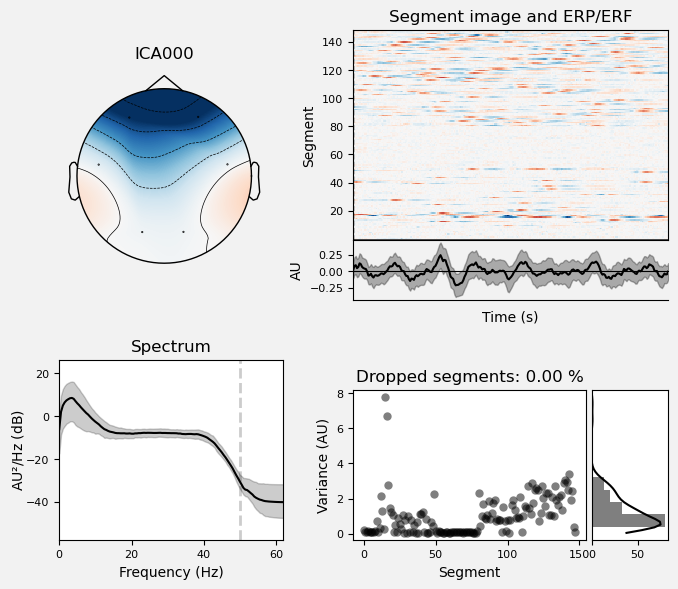

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Almaz 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
170 matching events found
No baseline correction applied
0 projection items activated


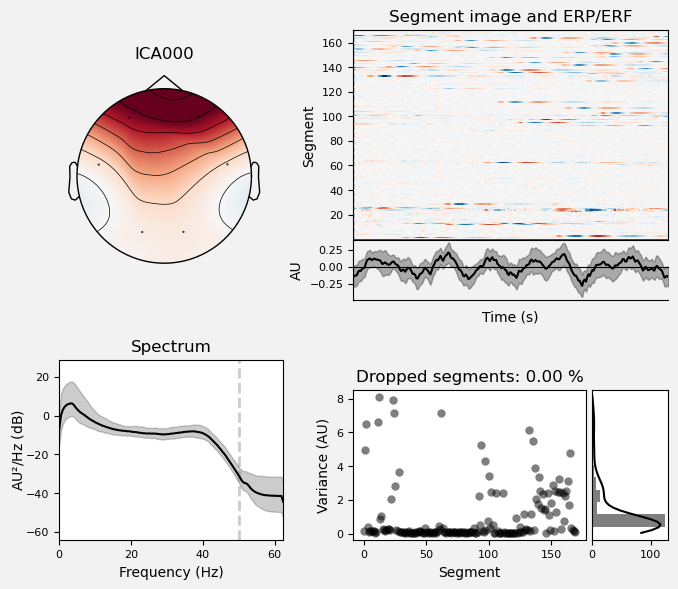

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Misha 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.3s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated


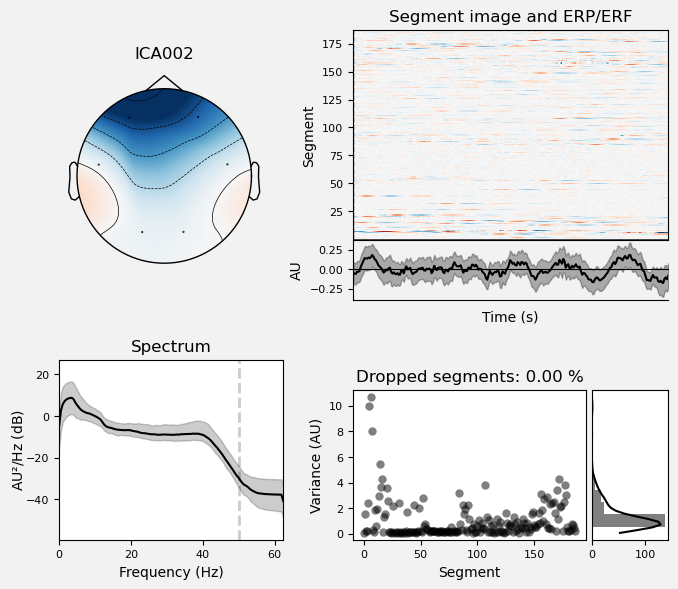

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Sasha 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
146 matching events found
No baseline correction applied
0 projection items activated


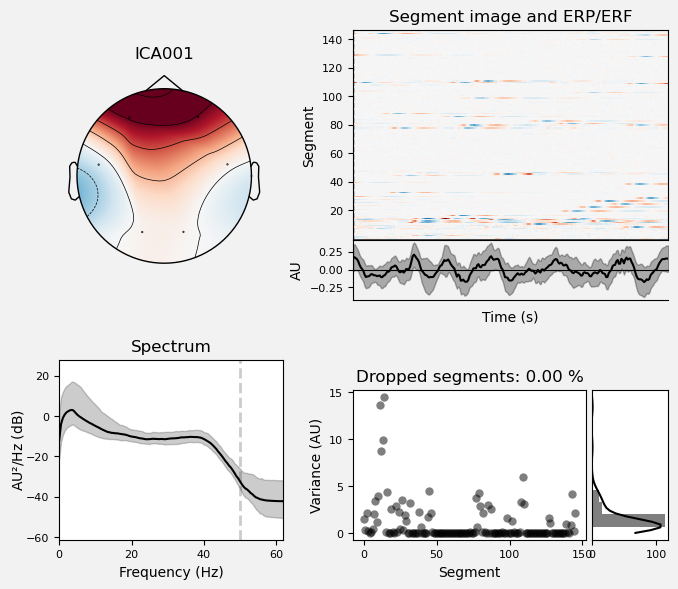

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 SonyN 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated


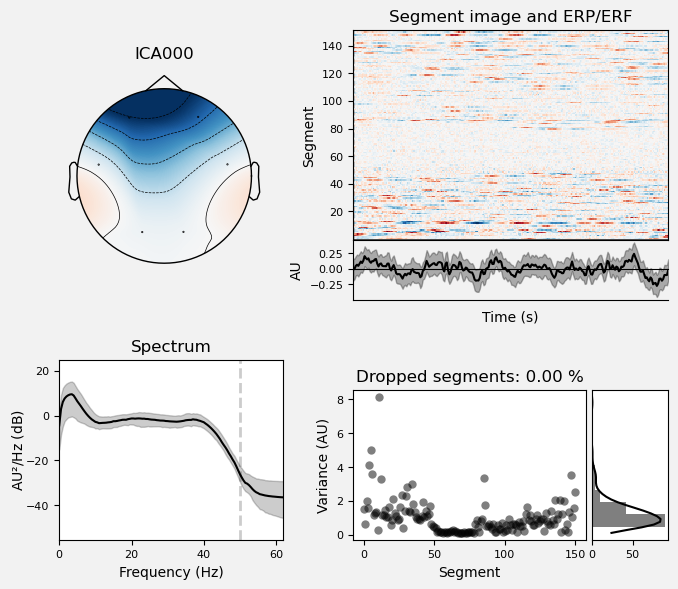

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Nasty 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
179 matching events found
No baseline correction applied
0 projection items activated


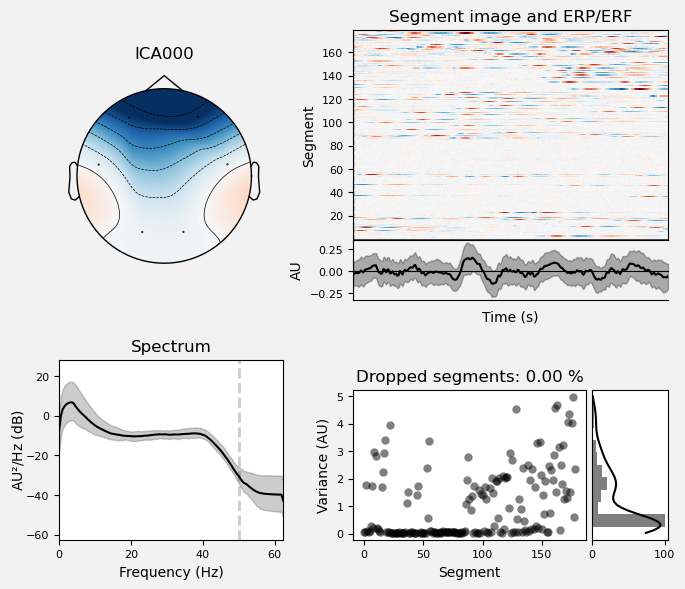

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Katya 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.2s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
170 matching events found
No baseline correction applied
0 projection items activated


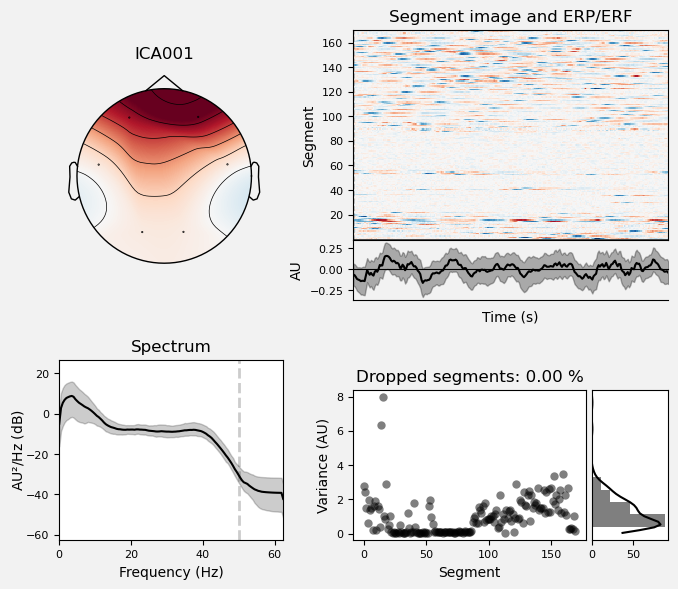

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Pilug 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
170 matching events found
No baseline correction applied
0 projection items activated


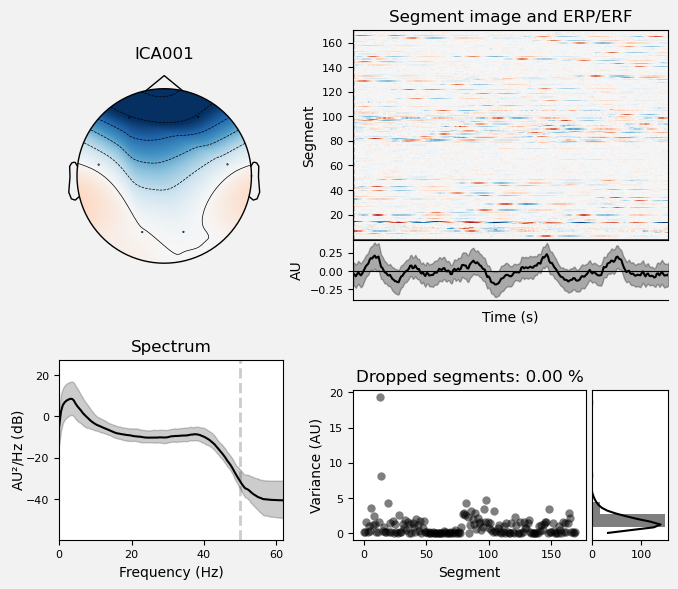

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Kurki 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.2s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated


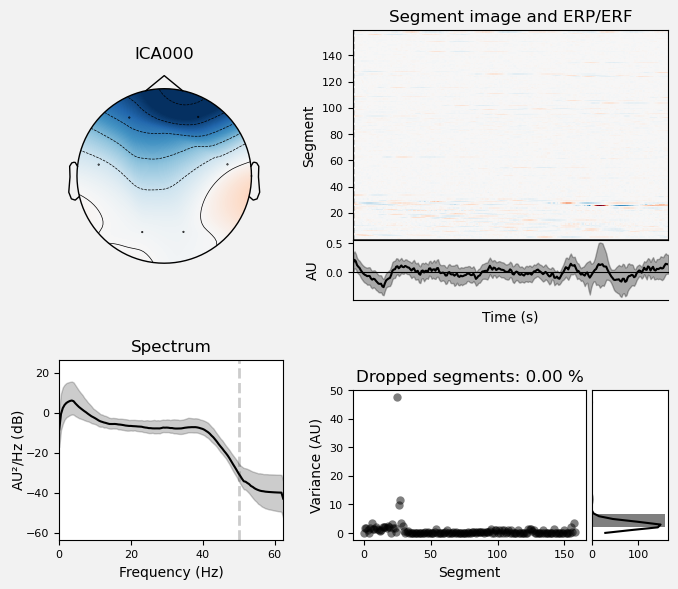

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Koblo 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
161 matching events found
No baseline correction applied
0 projection items activated


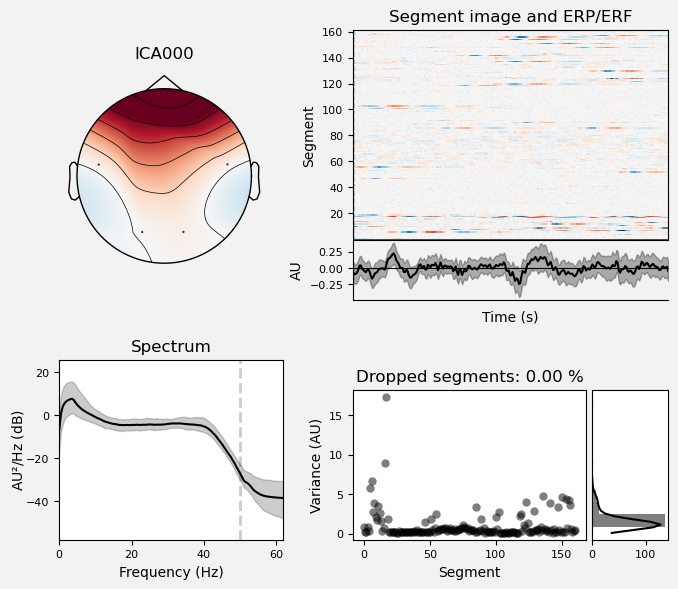

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Balts 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated


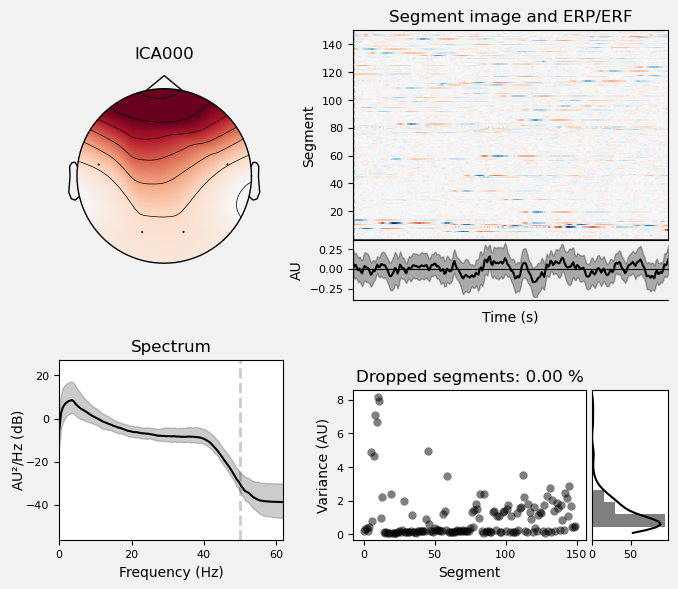

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Dolgi 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.2s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
157 matching events found
No baseline correction applied
0 projection items activated


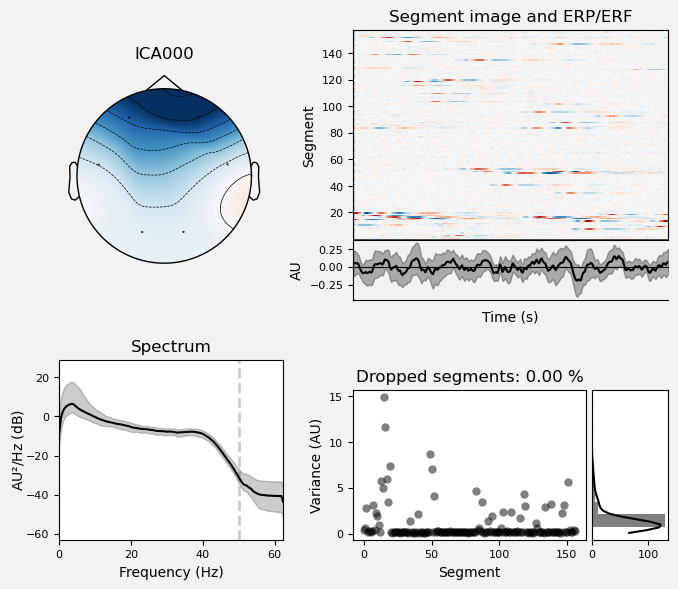

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components

 Mosgo 

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
152 matching events found
No baseline correction applied
0 projection items activated


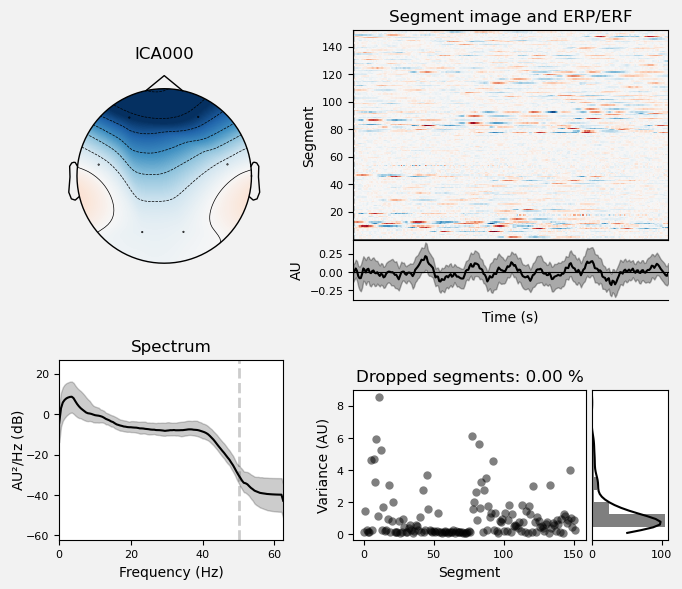

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 6 PCA components


In [16]:
#Рисуем коспоненты всех и исключаем компоненты глаз (выбранные руками)

special1 = ['Sasha', 'Katya', 'Pilug']
for i in names:
    print('\n', i, '\n')
    # set up and fit the ICA
    raw = raw_list[i]
    ica = mne.preprocessing.ICA(n_components=6, random_state=97, max_iter=800)
    ica.fit(raw, picks='all')
    #ica.plot_properties(raw, picks=[0,1,2,3,4,5])
    if i == 'Misha':
        ica.exclude = [2]
    elif i in special1:
        ica.exclude = [1]
    else:
        ica.exclude = [0]
    ica.plot_properties(raw, picks=ica.exclude)
    ica.apply(raw)

In [6]:
raw_list["Sasha"].plot(events = events_list["Sasha"])
raw_list["Koblo"].plot(events = events_list["Koblo"])

Using qt as 2D backend.


In [7]:
raw_list["Koblo"].plot(events = events_list["Koblo"])

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


### save raw eeg

In [25]:
#save filtered eeg
for i in names:
    print('\n', i, '\n')
    raw = raw_list[i]
    name = 'C:\\Users\\Lenovo\\1easyEEG\\eeg_raw\\' + i + "_neuroplay_" + "raw.fif"
    print(name)
    raw.save(name)


 Alice 

C:\Users\Lenovo\1easyEEG\eeg_raw\Alice_neuroplay_raw.fif
Writing C:\Users\Lenovo\1easyEEG\eeg_raw\Alice_neuroplay_raw.fif
Closing C:\Users\Lenovo\1easyEEG\eeg_raw\Alice_neuroplay_raw.fif
[done]

 Almaz 

C:\Users\Lenovo\1easyEEG\eeg_raw\Almaz_neuroplay_raw.fif
Writing C:\Users\Lenovo\1easyEEG\eeg_raw\Almaz_neuroplay_raw.fif
Closing C:\Users\Lenovo\1easyEEG\eeg_raw\Almaz_neuroplay_raw.fif
[done]

 Misha 

C:\Users\Lenovo\1easyEEG\eeg_raw\Misha_neuroplay_raw.fif
Writing C:\Users\Lenovo\1easyEEG\eeg_raw\Misha_neuroplay_raw.fif
Closing C:\Users\Lenovo\1easyEEG\eeg_raw\Misha_neuroplay_raw.fif
[done]

 Sasha 

C:\Users\Lenovo\1easyEEG\eeg_raw\Sasha_neuroplay_raw.fif
Writing C:\Users\Lenovo\1easyEEG\eeg_raw\Sasha_neuroplay_raw.fif
Closing C:\Users\Lenovo\1easyEEG\eeg_raw\Sasha_neuroplay_raw.fif
[done]

 SonyN 

C:\Users\Lenovo\1easyEEG\eeg_raw\SonyN_neuroplay_raw.fif
Writing C:\Users\Lenovo\1easyEEG\eeg_raw\SonyN_neuroplay_raw.fif
Closing C:\Users\Lenovo\1easyEEG\eeg_raw\SonyN_neuro

In [30]:
#save events
for i in names:
    print('\n', i, '\n')
    eve = events_list[i]
    name = 'C:\\Users\\Lenovo\\1easyEEG\\eeg_raw\\events\\' + i + "_neuroplay_" + "eve.npy"
    print(name)
    np.save(name, eve)


 Alice 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Alice_neuroplay_eve.npy

 Almaz 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Almaz_neuroplay_eve.npy

 Misha 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Misha_neuroplay_eve.npy

 Sasha 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Sasha_neuroplay_eve.npy

 SonyN 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\SonyN_neuroplay_eve.npy

 Nasty 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Nasty_neuroplay_eve.npy

 Katya 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Katya_neuroplay_eve.npy

 Pilug 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Pilug_neuroplay_eve.npy

 Kurki 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Kurki_neuroplay_eve.npy

 Koblo 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Koblo_neuroplay_eve.npy

 Balts 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Balts_neuroplay_eve.npy

 Dolgi 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Dolgi_neuroplay_eve.npy

 Mosgo 

C:\Users\Lenovo\1easyEEG\eeg_raw\events\Mosgo_neuroplay_eve.npy


## psd plots

In [8]:
import math

In [9]:
%matplotlib

Using matplotlib backend: QtAgg


In [12]:
psd = {}
#ec
for i in names:
    raw = raw_list[i]
    events = events_list[i]
    #if events[3][2] == 3:
        #eot1 = events[3][0] / raw.info['sfreq']
        #eot2 = events[4][0] / raw.info['sfreq']
        #print(eot1,eot2)
        #raw_eo = raw.copy().crop(tmin=eot1, tmax=eot2)
        #psd_eo = raw_eo.compute_psd(picks=['O1'])
    if events[5][2] == 4:
        ect1 = events[5][0] / raw.info['sfreq']
        ect2 = events[6][0] / raw.info['sfreq']
        print(ect1,ect2)
        raw_ec = raw.copy().crop(tmin=ect1, tmax=ect2)
        psd_ec = raw_ec.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_ec = psd_ec.get_data(return_freqs=True)
    yy_ec = psd_ec[0][0]
    x_ec = psd_ec[1]
    y_ec = []
    for i in range(len(yy_ec)):
        n = (yy_ec[i] ** 2) / x_ec[i]
        n = math.log(n,10)
        y_ec.append(n)
    plt.plot(x_ec,y_ec)
    
    

35.75118651789121 95.74494507647613
Effective window size : 2.050 (s)
99.25278999019395 160.0394176046192
Effective window size : 2.050 (s)
59.22833316971831 119.22586547151089
Effective window size : 2.051 (s)
124.87467159768126 185.857740287444
Effective window size : 2.051 (s)
42.89398909872109 102.87348309894958
Effective window size : 2.051 (s)
107.65550205169215 168.5962058916679
Effective window size : 2.051 (s)
29.99618673192916 90.01259560182268
Effective window size : 2.051 (s)
92.63245485965943 153.58624456492575
Effective window size : 2.051 (s)
30.766784914180775 90.73797894611909
Effective window size : 2.051 (s)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23004\1419247673.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  n = (yy_ec[i] ** 2) / x_ec[i]


95.06455807467576 156.06932378732483
Effective window size : 2.051 (s)
45.6557851101289 105.68112784965626
Effective window size : 2.051 (s)
111.06370462053462 171.88201625934317
Effective window size : 2.051 (s)
43.493843316382176 103.50524901991447
Effective window size : 2.052 (s)
109.39579164706407 170.41700465810774
Effective window size : 2.052 (s)
32.867546803143725 92.88027308013476
Effective window size : 2.052 (s)
95.74145674478298 156.73996899026625
Effective window size : 2.052 (s)
61.046458568894316 121.03541943029597
Effective window size : 2.051 (s)
123.82336793186752 184.77369034553524
Effective window size : 2.051 (s)
42.90176176691749 102.89212443931304
Effective window size : 2.051 (s)
110.00636616648815 170.9581128560695
Effective window size : 2.051 (s)
27.226756374782525 87.29848869374715
Effective window size : 2.049 (s)
91.38010120143059 152.3161749926105
Effective window size : 2.049 (s)
38.421770357858236 98.37318814576086
Effective window size : 2.050 (s)
105

In [14]:
#eo
for i in names:
    raw = raw_list[i]
    events = events_list[i]
    if events[3][2] == 3:
        eot1 = events[3][0] / raw.info['sfreq']
        eot2 = events[4][0] / raw.info['sfreq']
        print(eot1,eot2)
        raw_eo = raw.copy().crop(tmin=eot1, tmax=eot2)
        psd_eo = raw_eo.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_eo = psd_eo.get_data(return_freqs=True)
    #for ec
    yy_eo = psd_eo[0][0]
    x_eo = psd_eo[1]
    y_eo = []
    for i in range(len(yy_eo)):
        if x_eo[i] == 0:
            x_eo[i] = 0.1
        n = (yy_eo[i] ** 2) / x_eo[i]
        n = math.log(n,10)
        y_eo.append(n)
    plt.plot(x_eo,y_eo)

35.75118651789121 95.74494507647613
Effective window size : 2.050 (s)
59.22833316971831 119.22586547151089
Effective window size : 2.051 (s)
42.89398909872109 102.87348309894958
Effective window size : 2.051 (s)
29.99618673192916 90.01259560182268
Effective window size : 2.051 (s)
30.766784914180775 90.73797894611909
Effective window size : 2.051 (s)
45.6557851101289 105.68112784965626
Effective window size : 2.051 (s)
43.493843316382176 103.50524901991447
Effective window size : 2.052 (s)
32.867546803143725 92.88027308013476
Effective window size : 2.052 (s)
61.046458568894316 121.03541943029597
Effective window size : 2.051 (s)
42.90176176691749 102.89212443931304
Effective window size : 2.051 (s)
27.226756374782525 87.29848869374715
Effective window size : 2.049 (s)
38.421770357858236 98.37318814576086
Effective window size : 2.050 (s)
28.296060771006644 88.2270214022983
Effective window size : 2.050 (s)


In [27]:
#1b
for i in names:
    raw = raw_list[i]
    events = events_list[i]
    if (events[7][2] == 5) and (events[26][2] == 5):
        e1t1 = events[7][0] / raw.info['sfreq']
        e1t2 = events[26][0] / raw.info['sfreq']
        print(e1t1,e1t2)
        raw_e1 = raw.copy().crop(tmin=e1t1, tmax=e1t2)
        psd_e1 = raw_e1.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_e1 = psd_e1.get_data(return_freqs=True)
    #for 1 back
    yy_e1 = psd_e1[0][0]
    x_e1 = psd_e1[1]
    y_e1 = []
    for i in range(len(yy_e1)):
        if x_e1[i] == 0:
            x_e1[i] = 0.1
        n = (yy_e1[i] ** 2) / x_e1[i]
        n = math.log(n,10)
        y_e1.append(n)
    plt.plot(x_e1,y_e1)

165.01286895489037 222.17151998047046
Effective window size : 2.050 (s)
200.90519830864676 257.056734950068
Effective window size : 2.051 (s)
177.58351789330467 232.08411580697384
Effective window size : 2.051 (s)
158.60964442628247 214.92460076675525
Effective window size : 2.051 (s)
168.952914970138 226.47238082922755
Effective window size : 2.051 (s)
179.1869418769638 238.80378548655844
Effective window size : 2.051 (s)
188.13671860181898 246.3689400016408
Effective window size : 2.052 (s)
202.03803642049505 256.8813972529536
Effective window size : 2.052 (s)
189.26805560237904 244.18583427557726
Effective window size : 2.051 (s)
181.2208872395282 239.769173886145
Effective window size : 2.051 (s)
163.38454773403447 217.06975695274144
Effective window size : 2.049 (s)
177.2111046836801 233.48614294390774
Effective window size : 2.050 (s)
162.9785843219695 222.47717730141215
Effective window size : 2.050 (s)


In [28]:
#2b
#1b
for i in names:
    raw = raw_list[i]
    events = events_list[i]
    if (events[27][2] == 6) and (events[46][2] == 6):
        e1t1 = events[27][0] / raw.info['sfreq']
        e1t2 = events[46][0] / raw.info['sfreq']
        print(e1t1,e1t2)
        raw_e1 = raw.copy().crop(tmin=e1t1, tmax=e1t2)
        psd_e1 = raw_e1.compute_psd(picks=['O1'],fmin=0, fmax=60)
        psd_e1 = psd_e1.get_data(return_freqs=True)
    #for 1 back
    yy_e1 = psd_e1[0][0]
    x_e1 = psd_e1[1]
    y_e1 = []
    for i in range(len(yy_e1)):
        if x_e1[i] == 0:
            x_e1[i] = 0.1
        n = (yy_e1[i] ** 2) / x_e1[i]
        n = math.log(n,10)
        y_e1.append(n)
    plt.plot(x_e1,y_e1)

226.59236562515594 288.1238096253706
Effective window size : 2.050 (s)
265.9025249689221 325.08278319288576
Effective window size : 2.051 (s)
236.60180205378592 294.346483176602
Effective window size : 2.051 (s)
220.02010684621757 282.440056319631
Effective window size : 2.051 (s)
232.26518955135066 291.44317740972025
Effective window size : 2.051 (s)
245.00336051730224 311.3724544510791
Effective window size : 2.051 (s)
256.13041064091726 324.172188742278
Effective window size : 2.052 (s)
262.026719137279 327.08859305776684
Effective window size : 2.052 (s)
248.77633568764767 307.2511521042303
Effective window size : 2.051 (s)
245.70572019226748 307.5227124973161
Effective window size : 2.051 (s)
222.30382475671198 282.327538104998
Effective window size : 2.049 (s)
242.42479120727438 300.0454324318798
Effective window size : 2.050 (s)
227.3052827470593 287.98087655653535
Effective window size : 2.050 (s)


In [29]:
fig = mne.viz.plot_events(events)

## Classification csp + lda


 Alice 

Not setting metadata
40 matching events found
Setting baseline interval to [-0.20021945854553772, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 276 original time points ...
0 bad epochs dropped
<Epochs |  40 events (all good), -0.200219 - 2.00219 sec, baseline -0.200219 – 0 sec, ~532 kB, data loaded,
 '1-back': 20
 '2-back': 20>
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 6 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 6 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG 

Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 6 dim * 8.2e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 6 dim * 7.6e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 6 dim * 8e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalu

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

    Using tolerance 1.1e-06 (2.2e-16 eps * 6 dim * 8e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 9.8e-07 (2.2e-16 eps * 6 dim * 7.4e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 6 dim * 8.5e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing ran

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 6 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-06 (2.2e-16 eps * 6 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 6 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data 

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 6 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 6 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 6 dim * 9.7e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 dat

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 6 dim * 1e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 6 dim * 9.7e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 6 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Redu

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 6 dim * 9.4e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 6 dim * 8.4e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 6 dim * 1e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating 

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 6 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 6 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-06 (2.2e-16 eps * 6 dim * 

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 6 dim * 1e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-06 (2.2e-16 eps * 6 dim * 2.7e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 6 dim * 1.2e+09  max singular value)
 

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

    Using tolerance 1.2e-06 (2.2e-16 eps * 6 dim * 9.3e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 6 dim * 9.2e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 6 dim * 8.6e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing r

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 6 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 6 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 6 dim * 1.7e+09  max singular value)

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
7 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

    Using tolerance 1.1e-06 (2.2e-16 eps * 6 dim * 8.5e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 6 dim * 9.4e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 6 dim * 7.6e+08  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing ran

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 6 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 6 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 6 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigen

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 6 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 6 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 6 -> 5
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 6 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 6 dat

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_

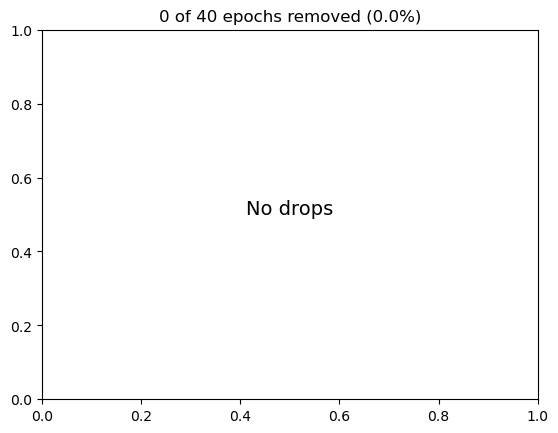

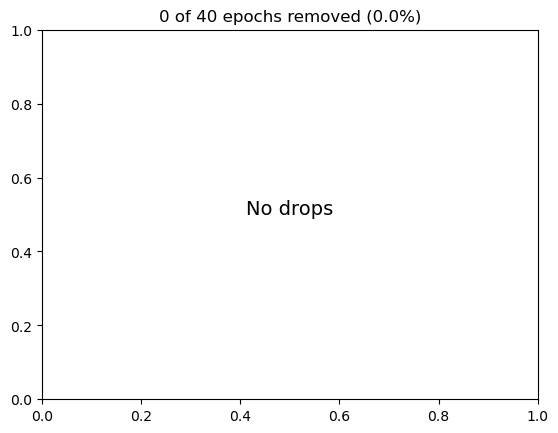

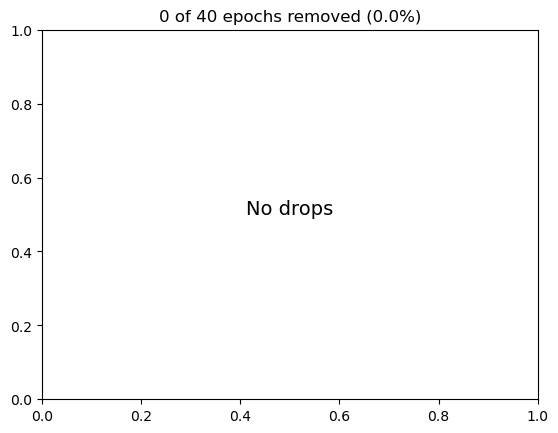

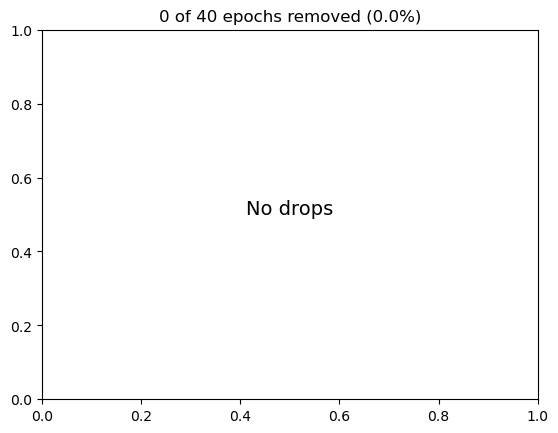

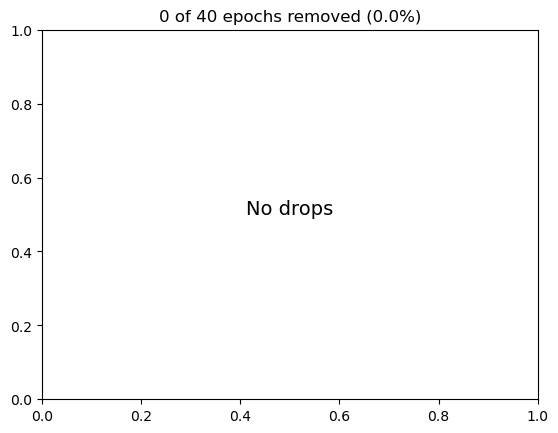

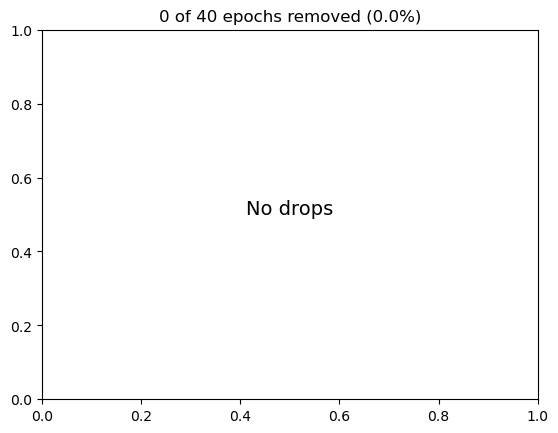

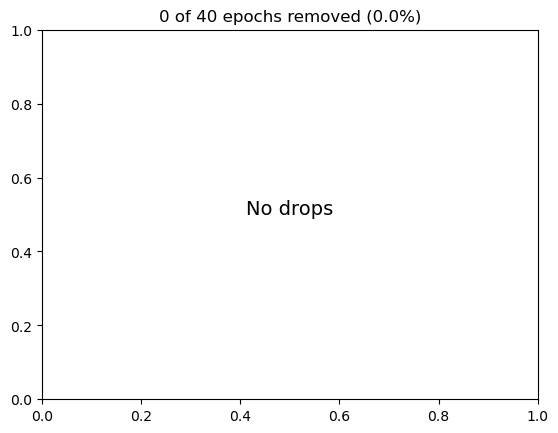

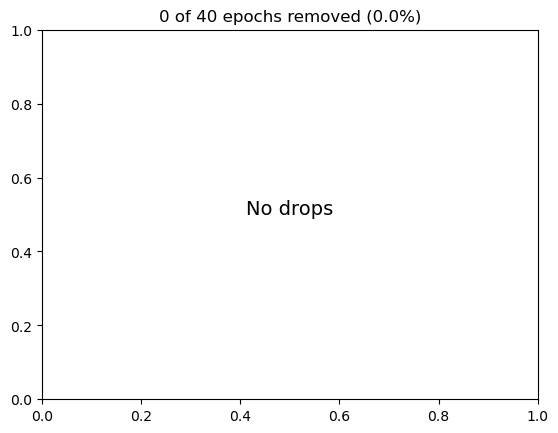

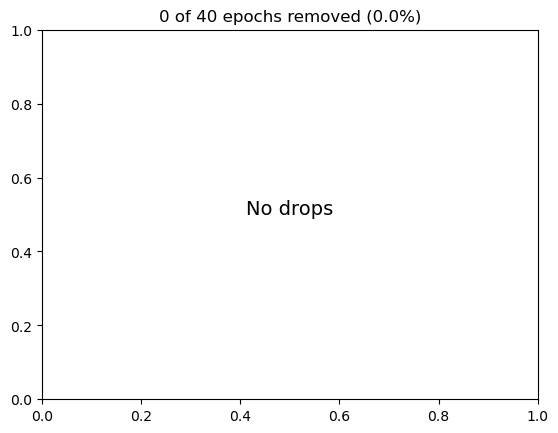

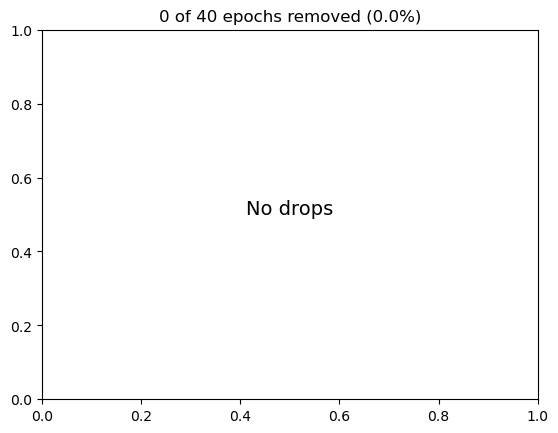

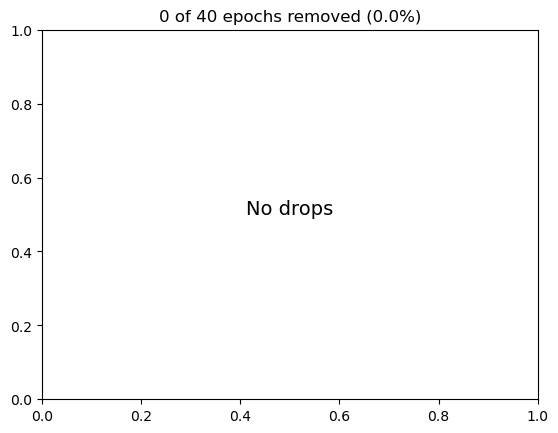

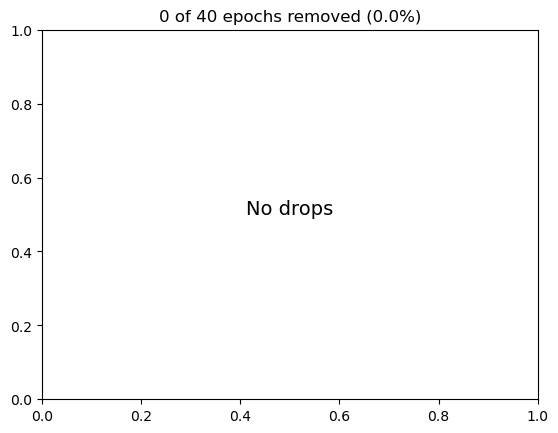

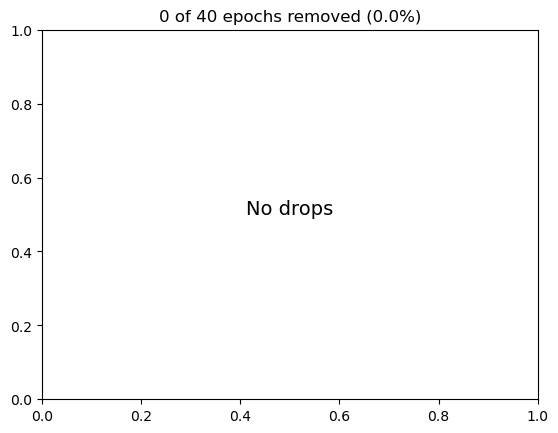

In [10]:
mm = []
n = 0
event_dict1 = {'1-back': 5, '2-back': 6}
for i in names:
    print('\n', i, '\n')
    raw = raw_list[i]
    events = events_list[i]
    events1 = events[7:]
    epo=mne.Epochs(raw,events1, event_id=event_dict1, tmin= -0.2, tmax=2, preload=True,picks=['O1','O2','F3','F4','T3','T4'],reject=None)
    epo.plot_drop_log()
    print(epo)
    #oneb = epo['1-back'].average(picks=['F3','F4'])
    #twob = epo['2-back'].average(picks=['F3','F4'])
    #fig1 = oneb.plot()
    #fig2 = twob.plot(spatial_colors=True)
    scores = []
    epochs_data = epo.get_data()
    cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data)
    
    lda = LinearDiscriminantAnalysis() #Создаеим объект модели классификации
    csp = CSP(n_components=3, log=True, reg=0.3, norm_trace=False) #Создаем объект CSP, который будет выделить 3 компонента
    labels = epo.events[:, -1]


    clf = Pipeline([('CSP', csp), ('LDA', lda)])# Идея данного оьъекта это объединить два объекта в жва блока последовательных преобразований

    scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1, verbose=False)
    print('--------------------------------------/////////////////////////////////------------------------------------------------------///////////////////////////////-----------')
    print(scores)
    
    n += np.count_nonzero(np.isnan(scores))
    
    cleanedList = [x for x in scores if str(x) != 'nan']
    print(statistics.mean(cleanedList))
    mm.append(statistics.mean(cleanedList))

In [11]:
#средние результаты по каждому испытуемому и по всем испытуемым
print(mm)
print(statistics.mean(mm))

[0.8333333333333334, 0.6, 0.5892857142857143, 0.6, 0.5, 0.5277777777777778, 0.71875, 0.53125, 0.6041666666666666, 0.7916666666666666, 0.6785714285714286, 0.5625, 0.59375]
0.6254655067155067


## ClumpsyClassificationWithTunung

In [12]:
def mean(data):
    return np.mean(data,axis=-1)
    
def std(data):
    return np.std(data,axis=-1)

def ptp(data):
    return np.ptp(data,axis=-1)

def var(data):
        return np.var(data,axis=-1)

def minim(data):
      return np.min(data,axis=-1)


def maxim(data):
      return np.max(data,axis=-1)

def argminim(data):
      return np.argmin(data,axis=-1)


def argmaxim(data):
      return np.argmax(data,axis=-1)

def mean_square(data):
      return np.mean(data**2,axis=-1)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=-1))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=-1)),axis=-1)


def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data)),axis=-1)

Not setting metadata
20 matching events found
Setting baseline interval to [-0.20021945854553772, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20021945854553772, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
shapes:
(40, 6, 276) (40,) (40,)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nAliceResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.5
Best parameters:
{'classifier__C': 0.05}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20031227397767287, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20031227397767287, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from pr

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nAlmazResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.6399999999999999
Best parameters:
{'classifier__C': 0.5}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20025204994734402, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20025204994734402, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Usin

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nMishaResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.52
Best parameters:
{'classifier__C': 3}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.2002950502933304, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.2002950502933304, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloa

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nSashaResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.64
Best parameters:
{'classifier__C': 0.5}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.2003045892850311, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.2003045892850311, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from prel

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nSonyNResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.62
Best parameters:
{'classifier__C': 4}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20024467153565306, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20024467153565306, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from prel

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nNastyResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.6599999999999999
Best parameters:
{'classifier__C': 5}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.2003585927601906, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.2003585927601906, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using da

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nKatyaResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.76
Best parameters:
{'classifier__C': 0.5}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20036300172606517, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20036300172606517, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from pr

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nPilugResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.7
Best parameters:
{'classifier__C': 0.1}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20028365672209422, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20028365672209422, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from pre

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nKurkiResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.5399999999999999
Best parameters:
{'classifier__C': 1}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20028833691371375, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20028833691371375, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nKobloResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.8400000000000001
Best parameters:
{'classifier__C': 0.05}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20007904449428662, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20007904449428662, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Usi

C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\epochs.py:619: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nBaltsResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.8
Best parameters:
{'classifier__C': 0.5}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20023853636574024, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20023853636574024, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from pre

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nDolgiResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.54
Best parameters:
{'classifier__C': 2}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20017020918935088, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
Setting baseline interval to [-0.20017020918935088, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from prel

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4996\529057372.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/40 [00:00<?, ?it/s]

/n/nMosgoResults/n
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Best score:
0.78
Best parameters:
{'classifier__C': 0.05}
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________


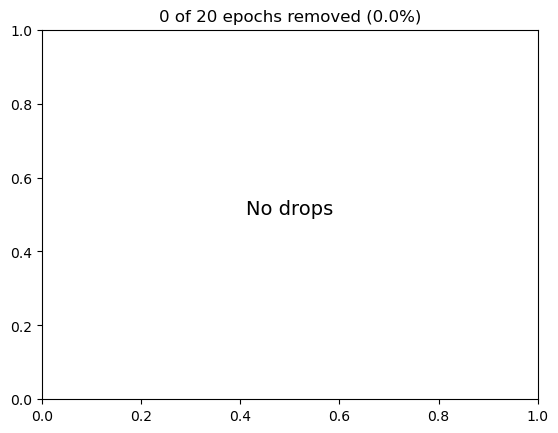

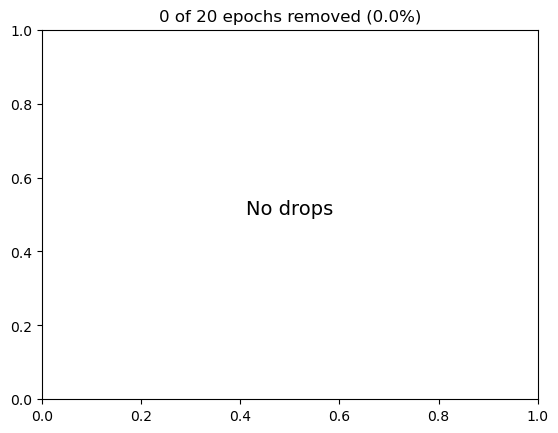

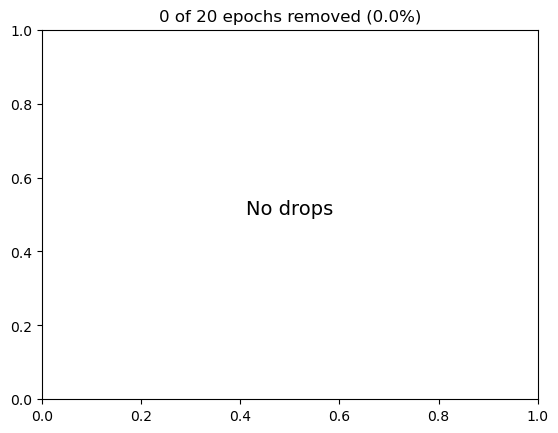

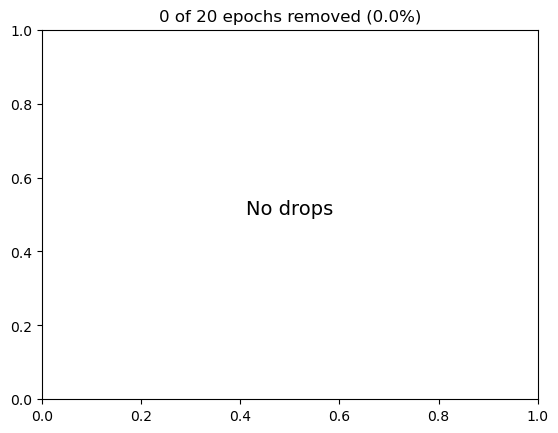

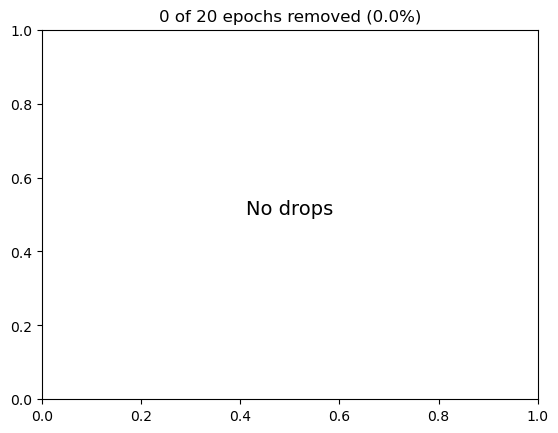

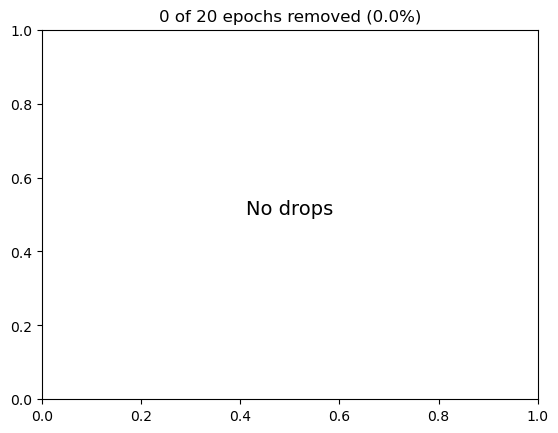

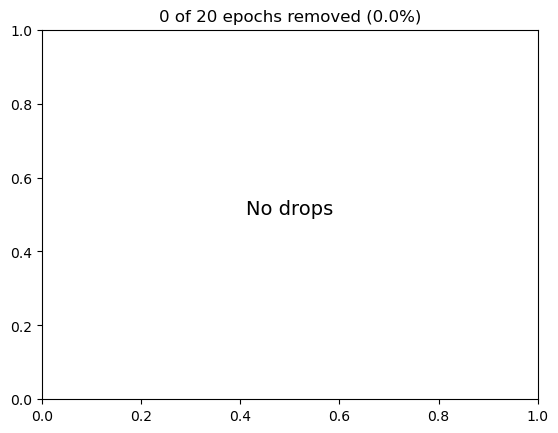

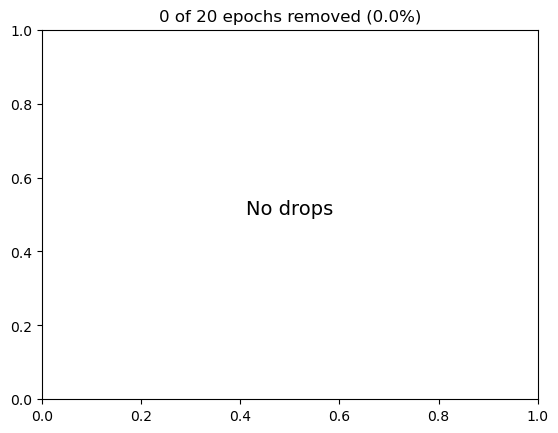

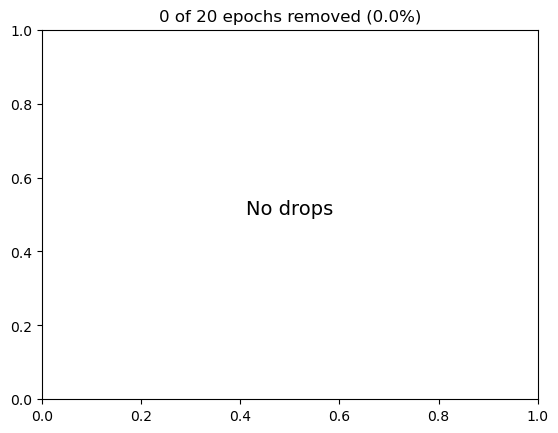

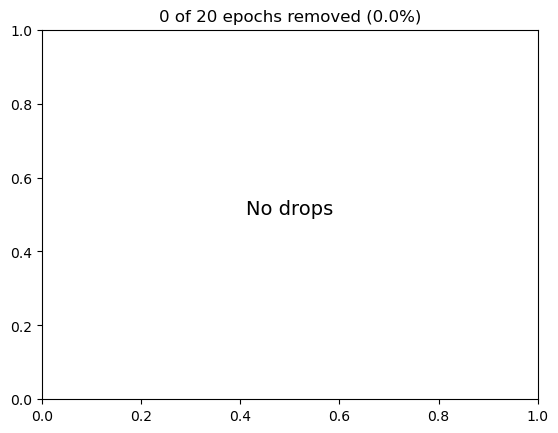

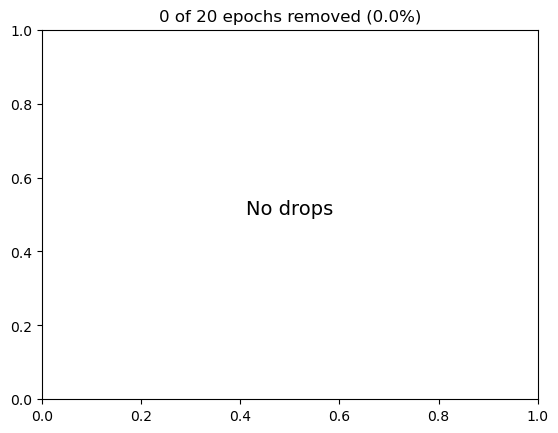

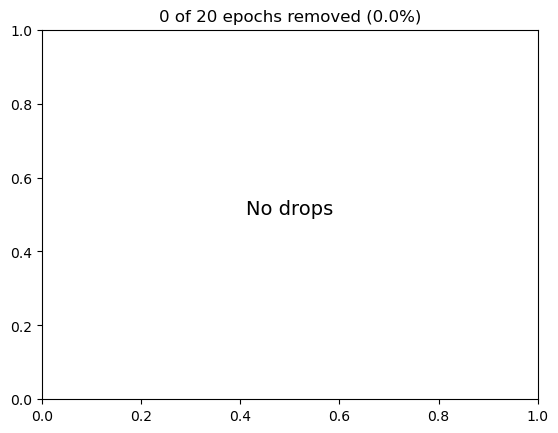

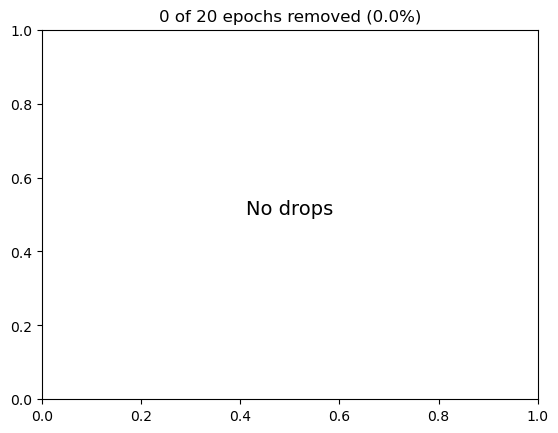

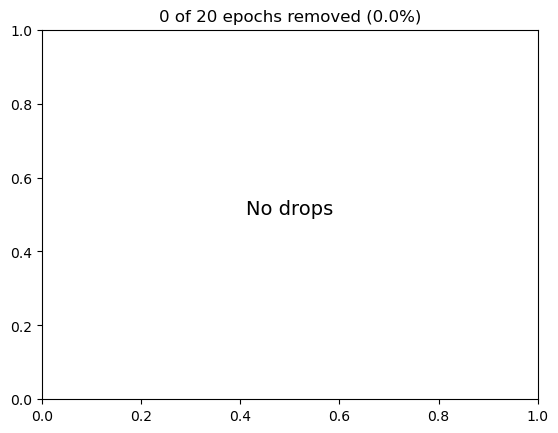

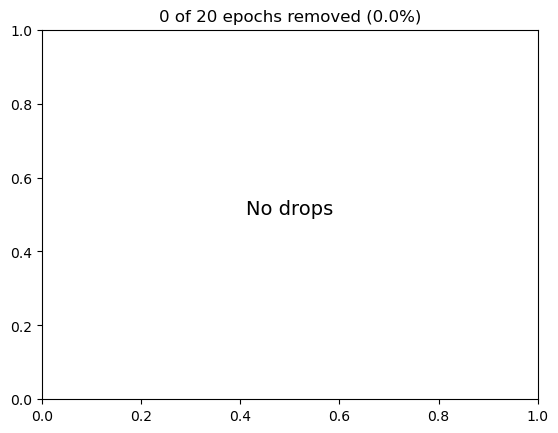

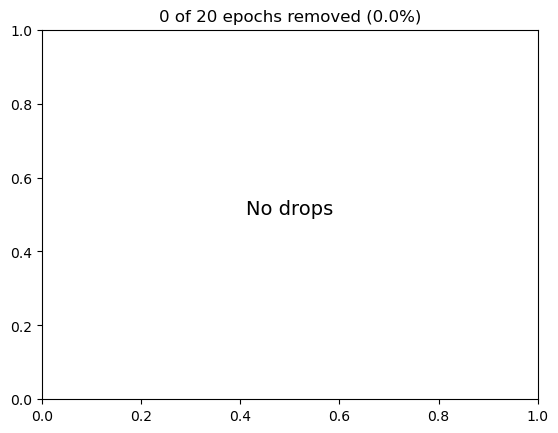

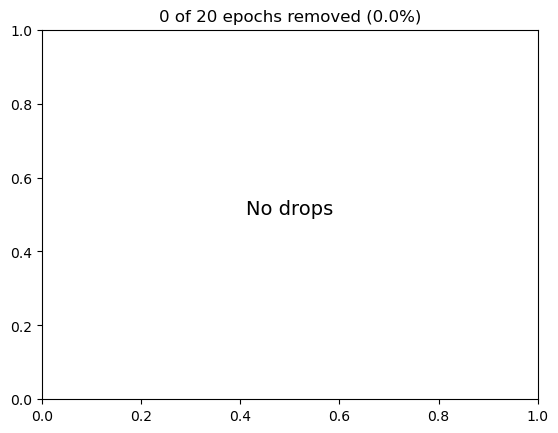

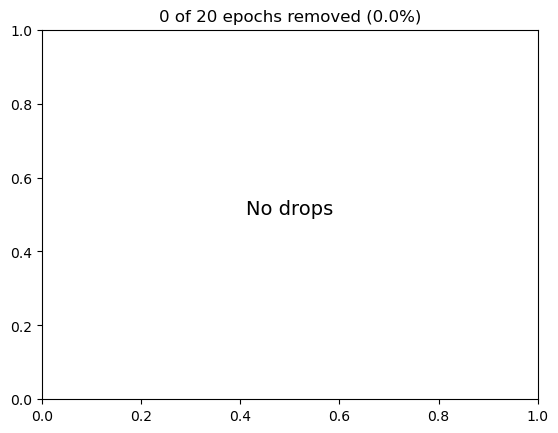

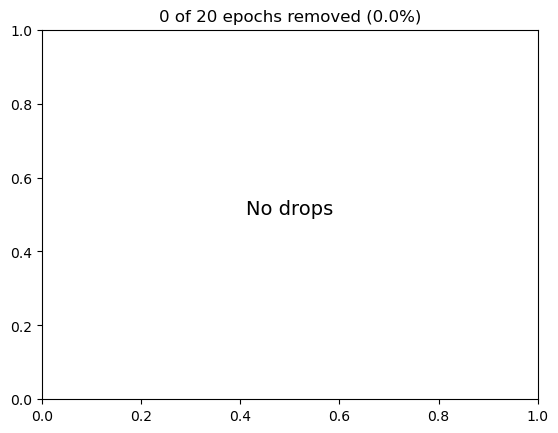

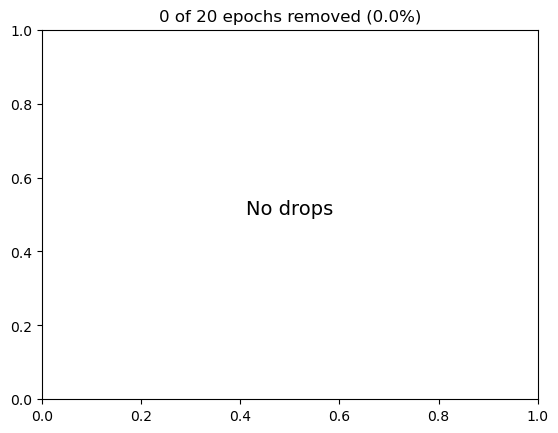

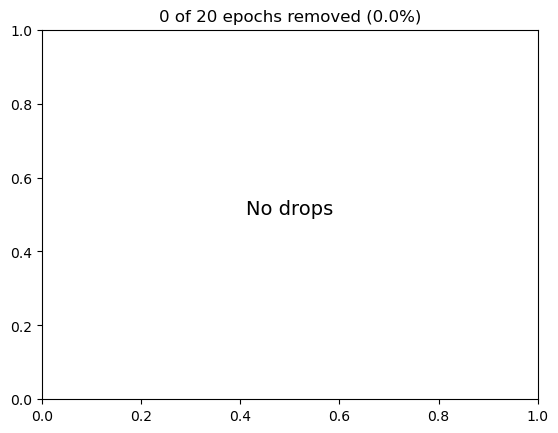

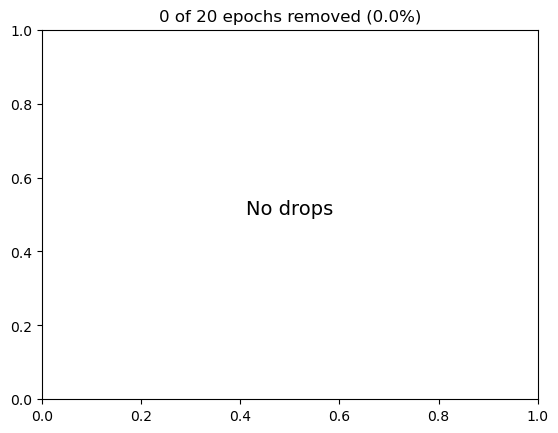

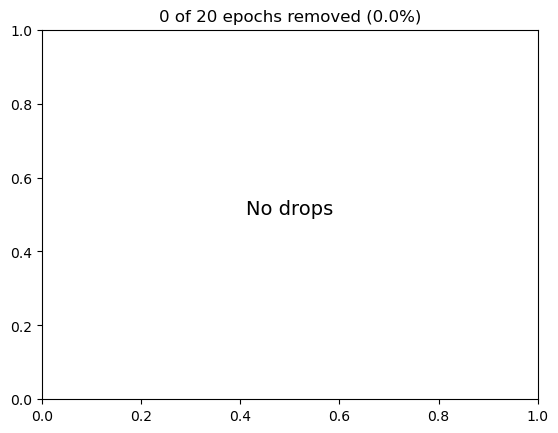

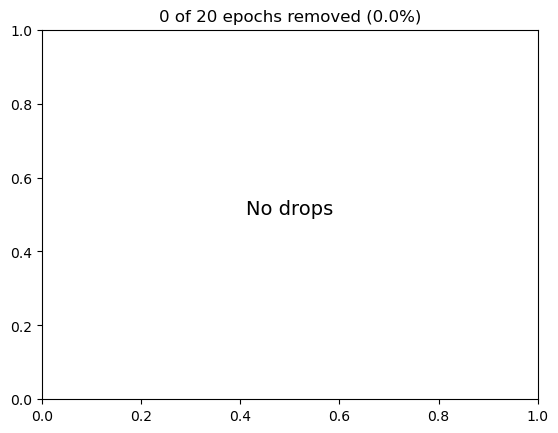

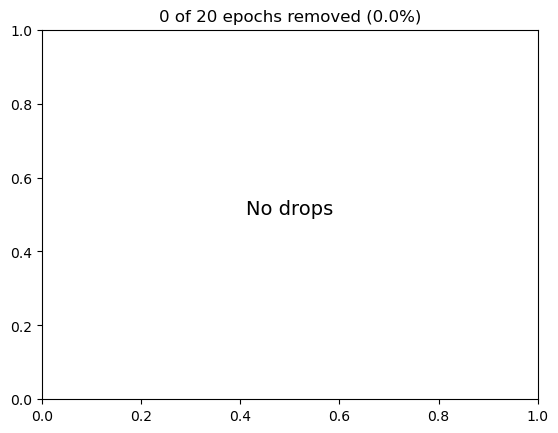

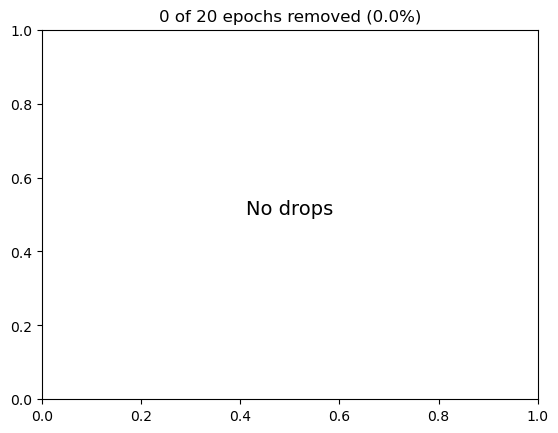

In [13]:
scores = []
for i in names:
    raw = raw_list[i]
    events = events_list[i]
    events11 = events[7:27]
    event_dict11 = {'1-back': 5}
    epochs1b = mne.Epochs(raw,events11, event_id=event_dict11, tmin= -0.2, tmax=2, preload=True,picks=['O1','O2','F3','F4','T3','T4'],reject=None)
    epochs1b.plot_drop_log()
    epochs1b = epochs1b.get_data()

    events1 = events[27:]
    event_dict1 = {'2-back': 6}

    epochs2b=mne.Epochs(raw,events1, event_id=event_dict1, tmin= -0.2, tmax=2, preload=True,picks=['O1','O2','F3','F4','T3','T4'],reject=None)
    epochs2b.plot_drop_log()
    epochs2b = epochs2b.get_data()
    
    b_epochs_labels = [1] * 20
    bb_epochs_labels = [2] * 20
    label_list=b_epochs_labels+bb_epochs_labels
    label_array=np.array(label_list)

    group_array = [0] * 5 + [1] * 5 + [2] * 5 + [3] * 5 + [4] * 5 + [5] * 5 + [6] * 5 + [7] * 5
    group_array=np.array(group_array)

    #data_list=[i for i in epochs1b]+[l for l in epochs2b]

    data_array = np.concatenate((epochs1b, epochs2b), axis=0)
    print('shapes:')
    print(data_array.shape,label_array.shape,group_array.shape)
    
    #делаем фичи - в каждой эпохе 13 параметров (типа среднего, минимального и т.д.) на каждый из 6 каналов = итого78 
    features=[]
    for data in tqdm_notebook(data_array):
        features.append(concatenate_features(data))
    features=np.array(features)
    features.shape
    
    #GridSearchCV это hyperparametric tunung, то есть чтобы подобрать идеальные параметры для классификатора
    #в данном случае подбираем только параметр С - Inverse of regularization strength;
    
    clf=LogisticRegression()
    gkf=GroupKFold(n_splits=5)
    param_grid = {'classifier__C': [0.01,0.05,0.1,0.5, 1,2,3,4,5,8, 10,12,15]}
    pipe=Pipeline([('scaler',StandardScaler()),('classifier',clf)])
    gscv=GridSearchCV(pipe,param_grid,cv=gkf,n_jobs=16)
    gscv.fit(features,label_array,groups=group_array)
    
    print('/n/n'+i+'Results'+'/n')
    print('_________________________________________________________________________________________________________________________________________________________________________________________________________________________________')
    print('Best score:')
    print(gscv.best_score_)
    scores.append(gscv.best_score_)
    print('Best parameters:')
    print(gscv.best_params_)
    print('_________________________________________________________________________________________________________________________________________________________________________________________________________________________________')


In [14]:
print(sum(scores)/len(scores))

0.6569230769230768


## ERPs

In [15]:
event_dict = {'blinking starts': 2, 'blinking ends': 22, 'EO start': 3, 'EO end': 33,
              'EC start': 4, 'EC end': 44, '1-back': 5, '2-back': 6}


 Alice 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20021945854553772, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200219 - 1.0011 sec, baseline -0.200219 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


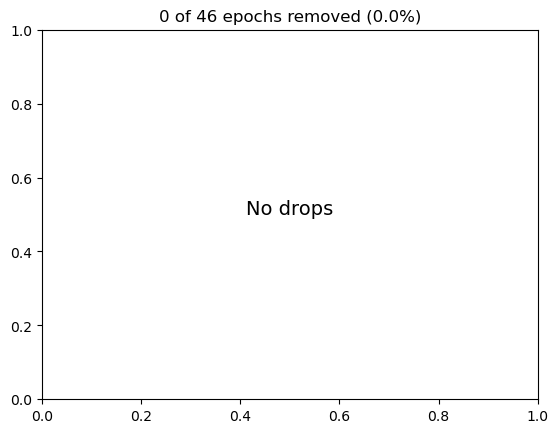

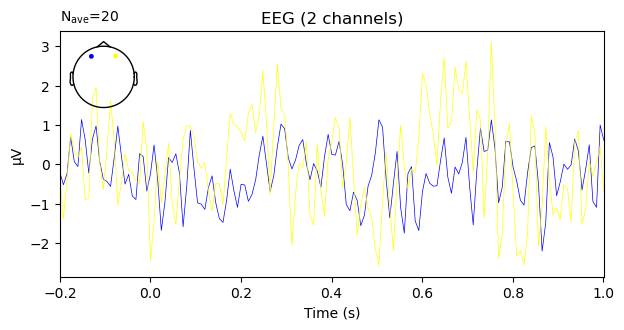

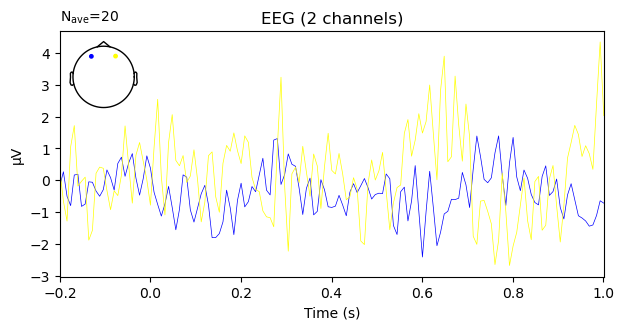


 Almaz 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20031227397767287, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200312 - 1.00156 sec, baseline -0.200312 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


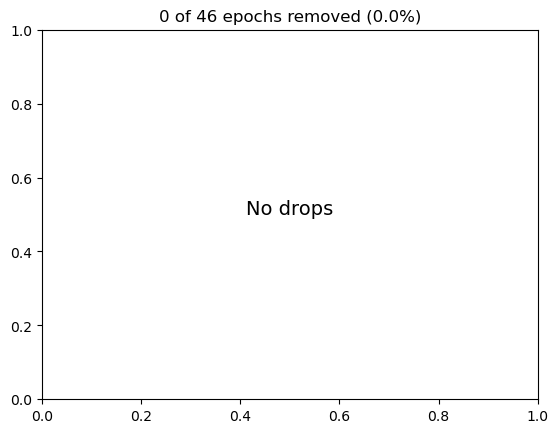

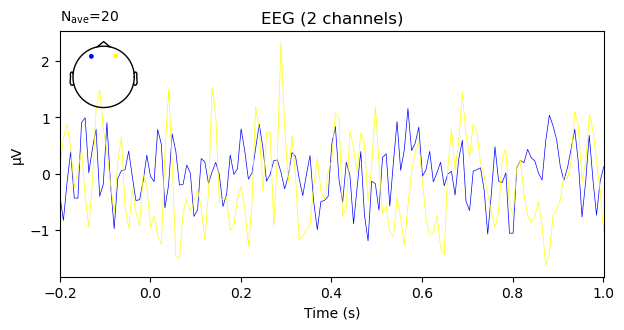

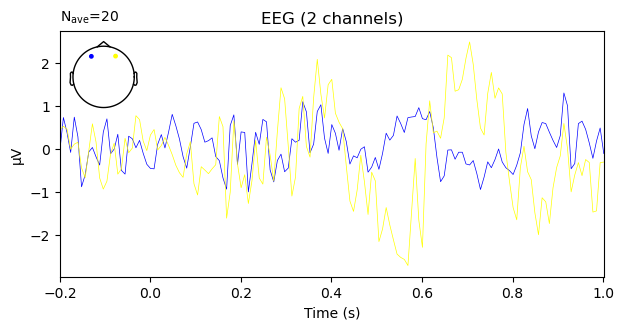


 Misha 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20025204994734402, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200252 - 1.00126 sec, baseline -0.200252 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


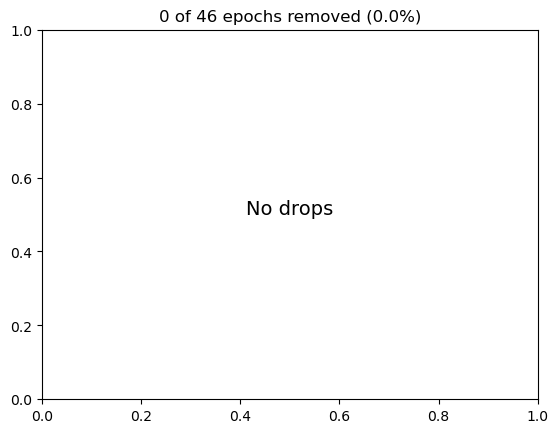

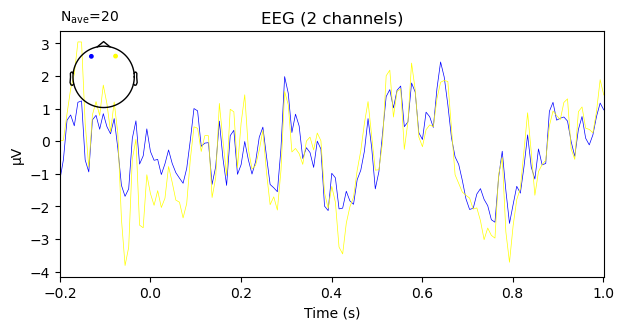

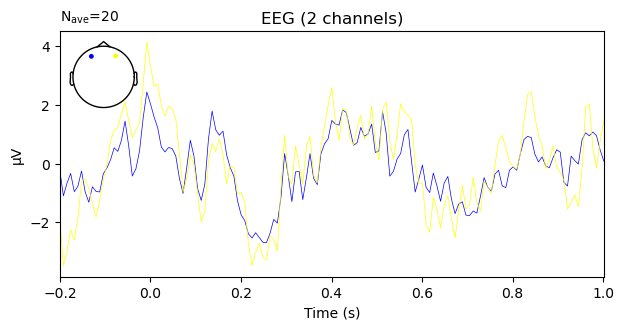


 Sasha 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.2002950502933304, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200295 - 1.00148 sec, baseline -0.200295 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


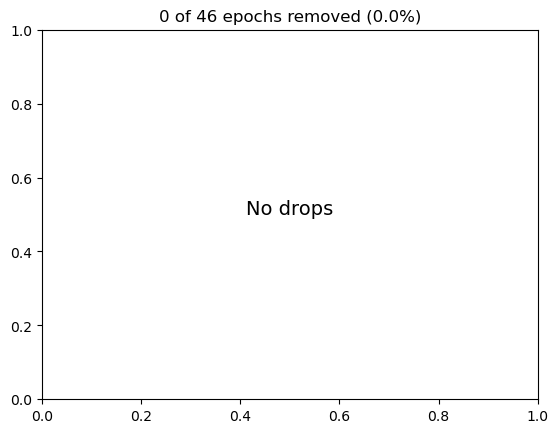

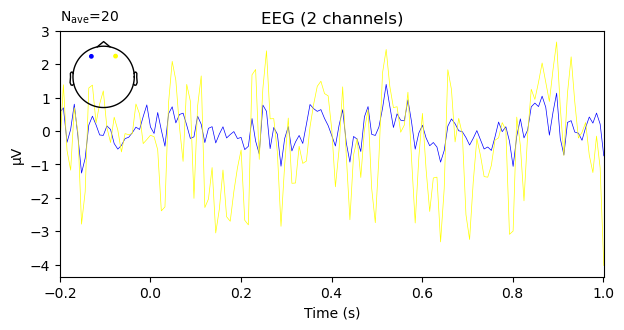

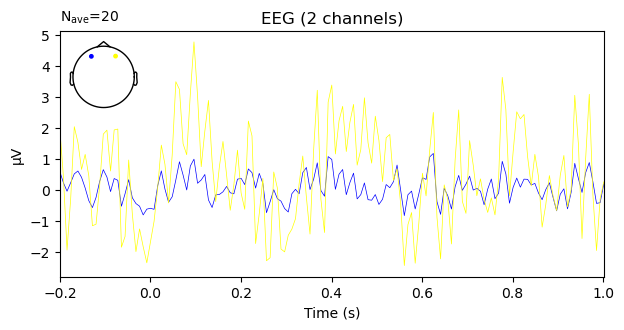


 SonyN 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.2003045892850311, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200305 - 1.00152 sec, baseline -0.200305 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


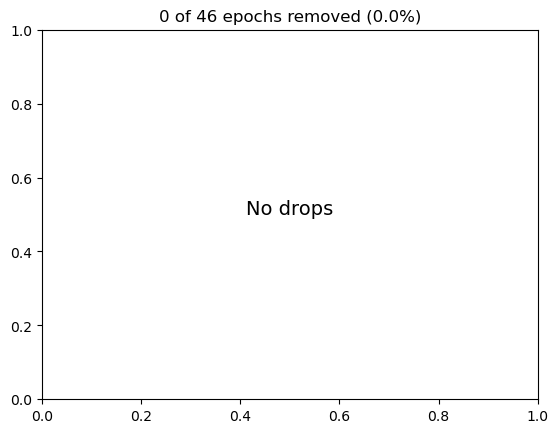

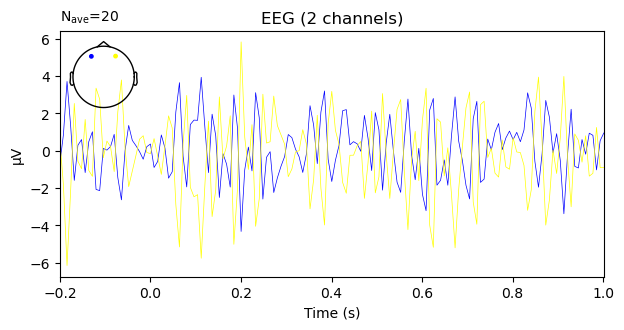

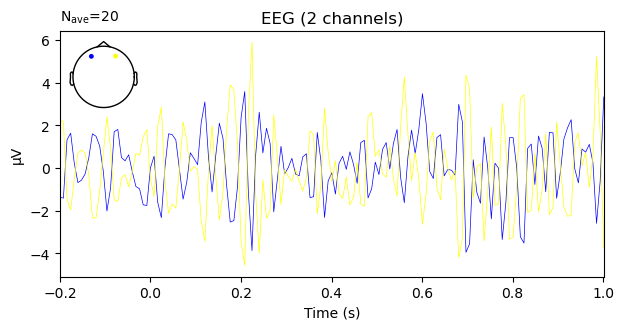


 Nasty 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20024467153565306, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200245 - 1.00122 sec, baseline -0.200245 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


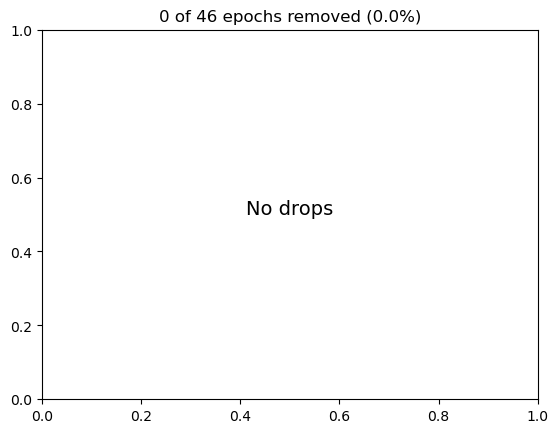

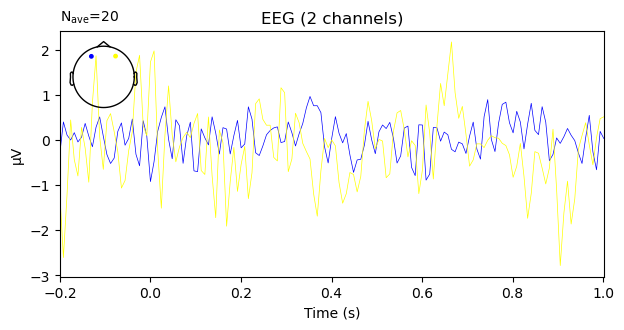

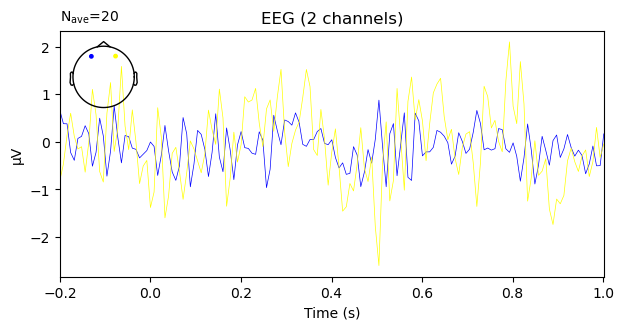


 Katya 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.2003585927601906, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200359 - 1.00179 sec, baseline -0.200359 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


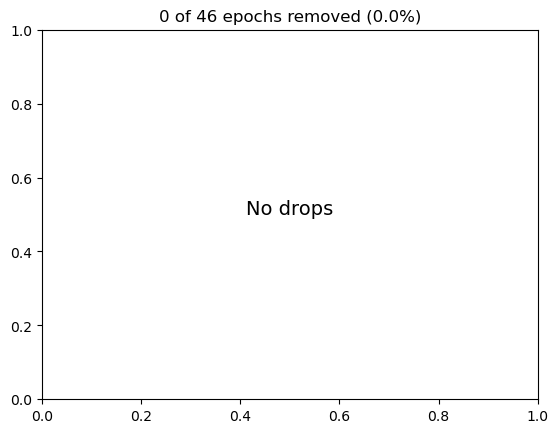

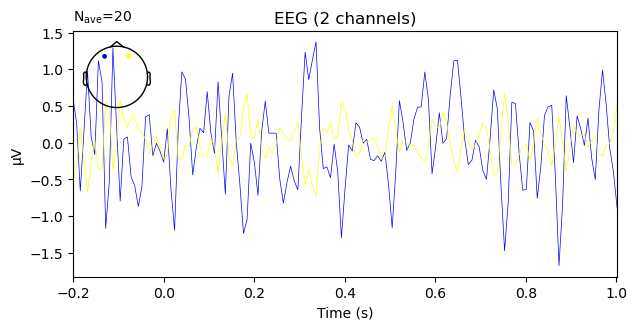

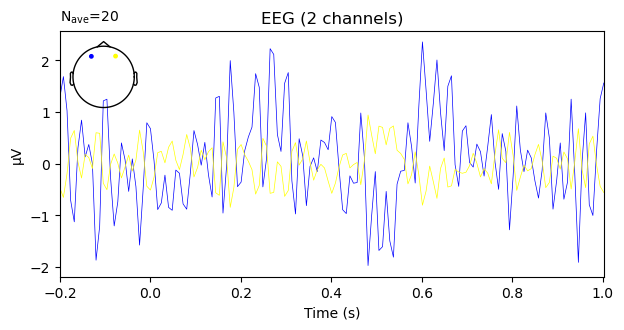


 Pilug 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20036300172606517, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200363 - 1.00182 sec, baseline -0.200363 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


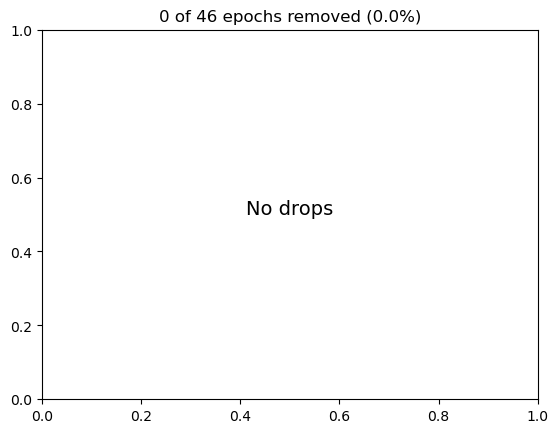

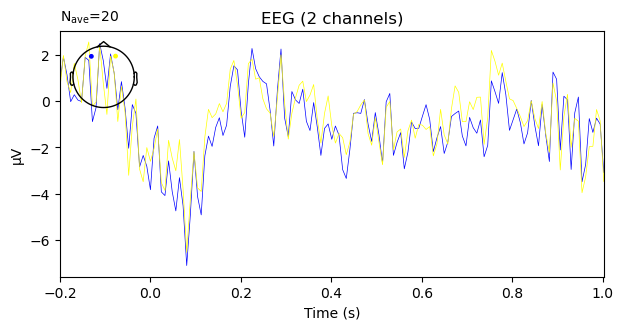

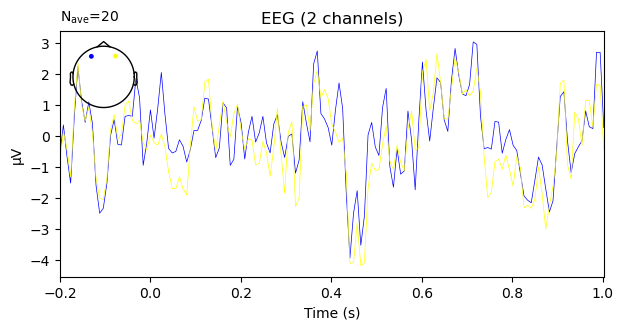


 Kurki 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20028365672209422, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200284 - 1.00142 sec, baseline -0.200284 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


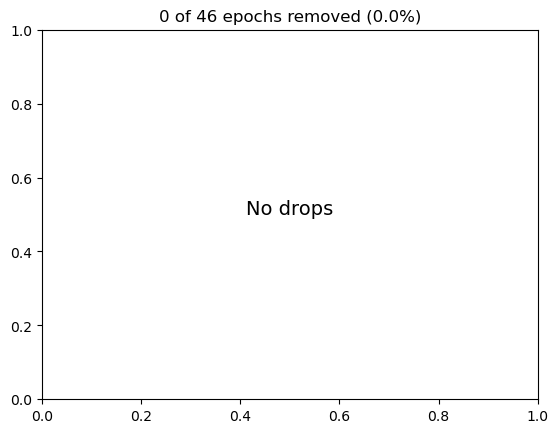

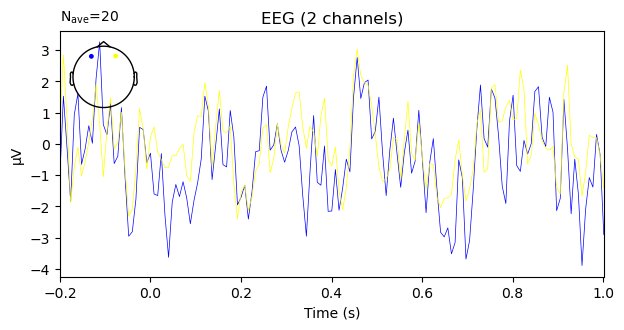

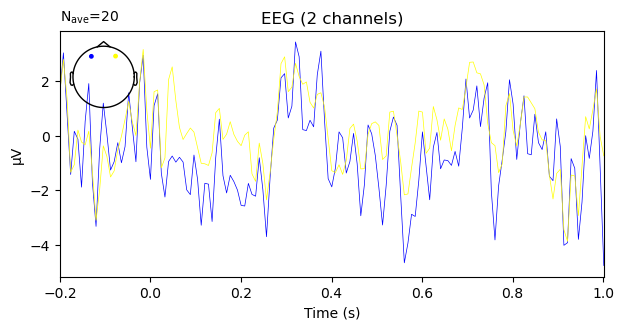


 Koblo 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20028833691371375, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200288 - 1.00144 sec, baseline -0.200288 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


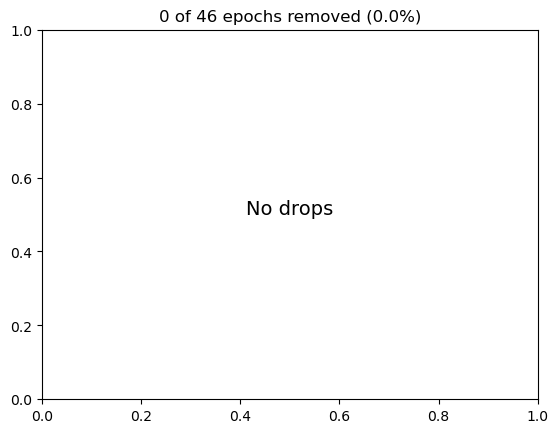

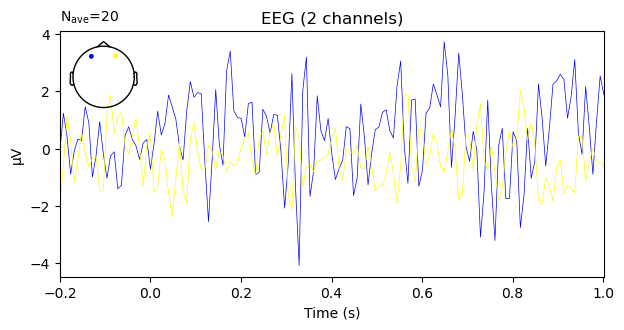

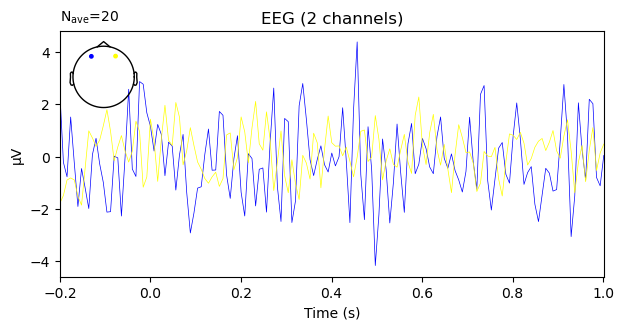


 Balts 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20007904449428662, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200079 - 1.0004 sec, baseline -0.200079 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


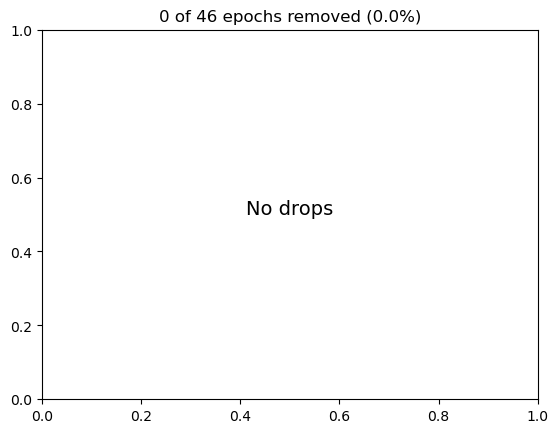

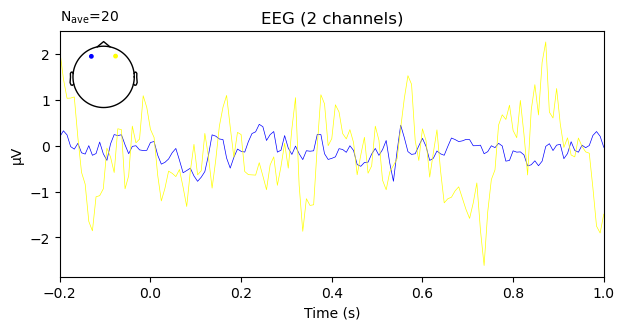

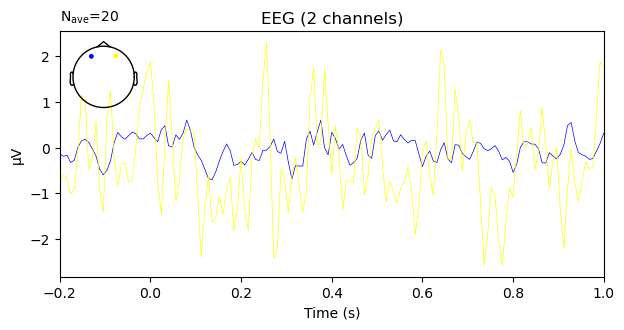


 Dolgi 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20023853636574024, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200239 - 1.00119 sec, baseline -0.200239 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


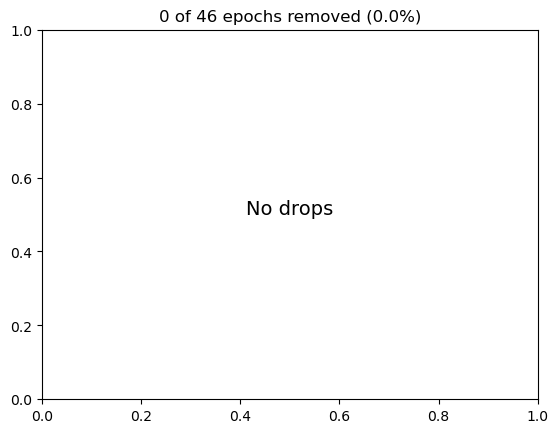

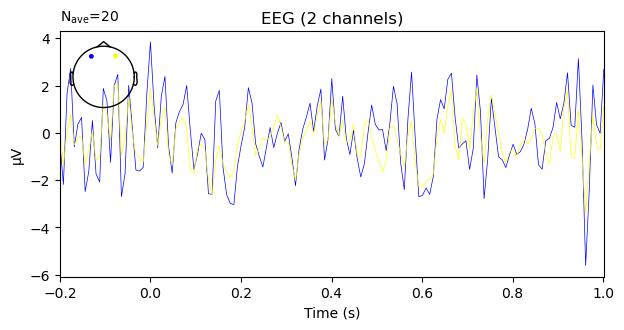

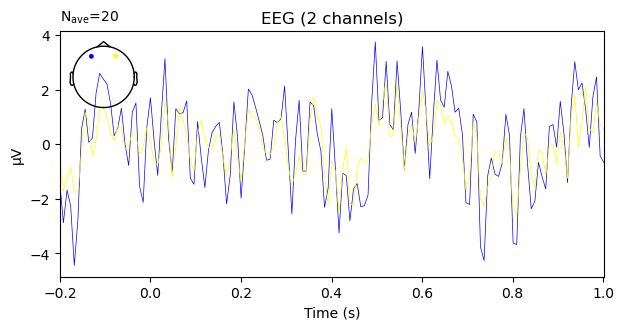


 Mosgo 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20017020918935088, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.20017 - 1.00085 sec, baseline -0.20017 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


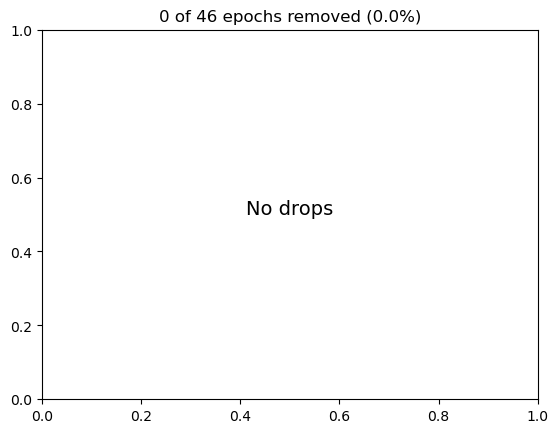

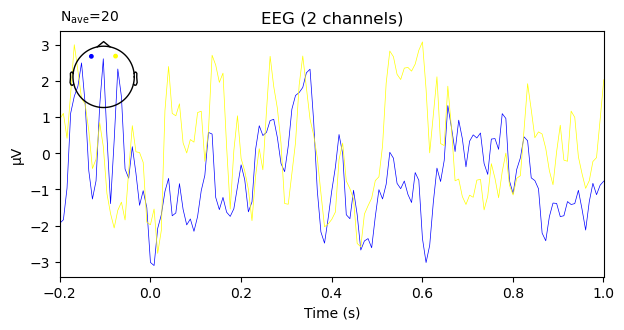

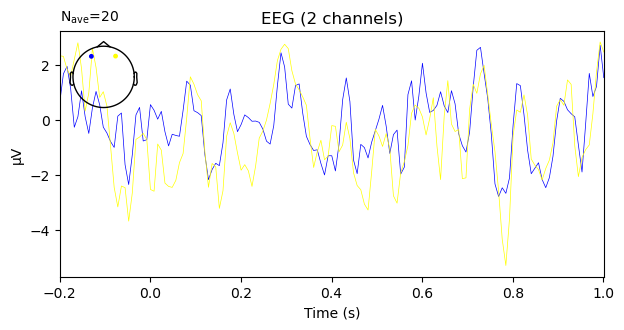

In [16]:
for i in names:
    print('\n', i, '\n')
    raw = raw_list[i]
    events = events_list[i]
    epo=mne.Epochs(raw,events, event_id=event_dict, tmin= -0.2, tmax=1, preload=True,picks=['O1','O2','F3','F4','T3','T4'],reject=None)
    epo.plot_drop_log()
    print(epo)
    oneb = epo['1-back'].average(picks=['F3','F4'])
    twob = epo['2-back'].average(picks=['F3','F4'])
    fig1 = oneb.plot()
    fig2 = twob.plot(spatial_colors=True)


 Alice 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20021945854553772, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200219 - 1.0011 sec, baseline -0.200219 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


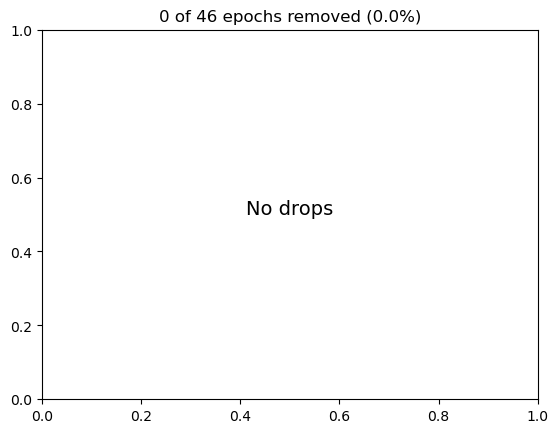

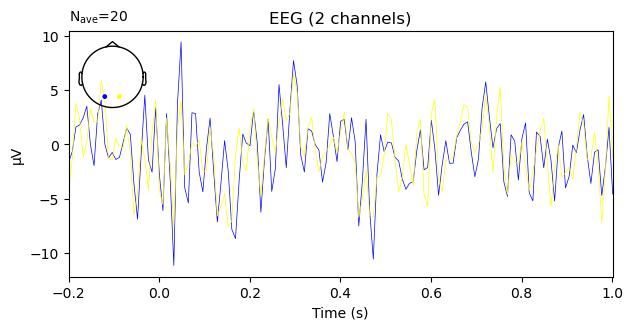

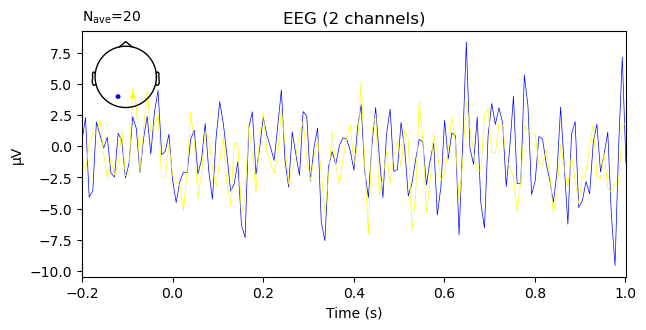


 Almaz 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20031227397767287, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200312 - 1.00156 sec, baseline -0.200312 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


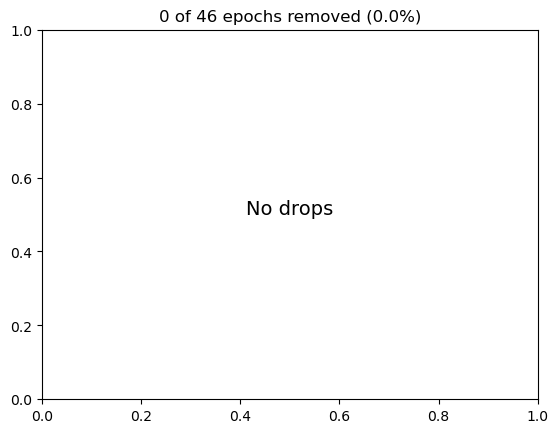

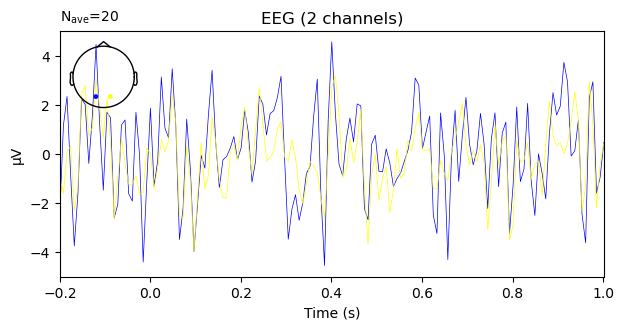

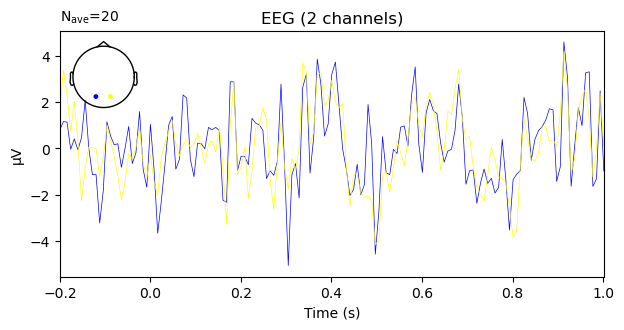


 Misha 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20025204994734402, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200252 - 1.00126 sec, baseline -0.200252 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


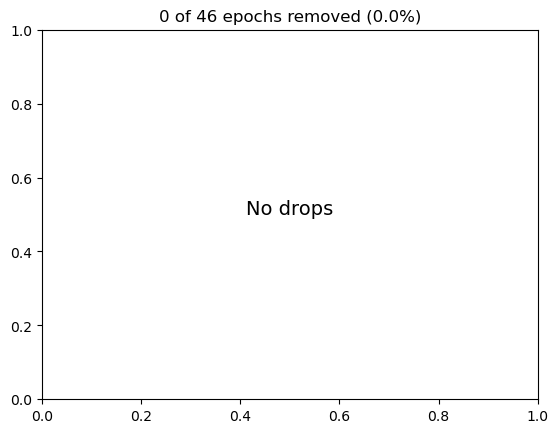

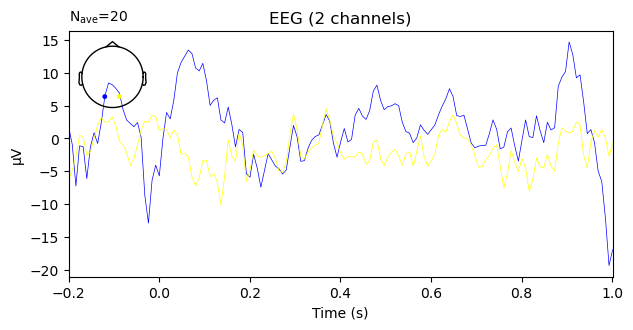

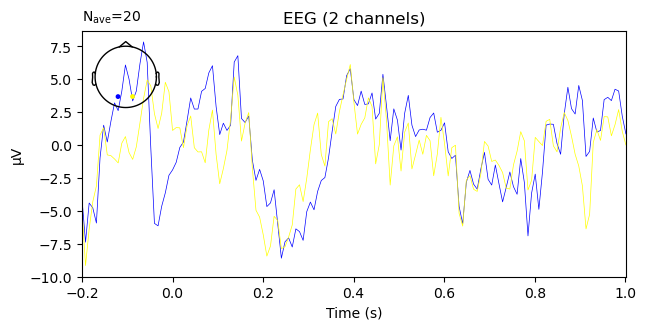


 Sasha 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.2002950502933304, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200295 - 1.00148 sec, baseline -0.200295 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


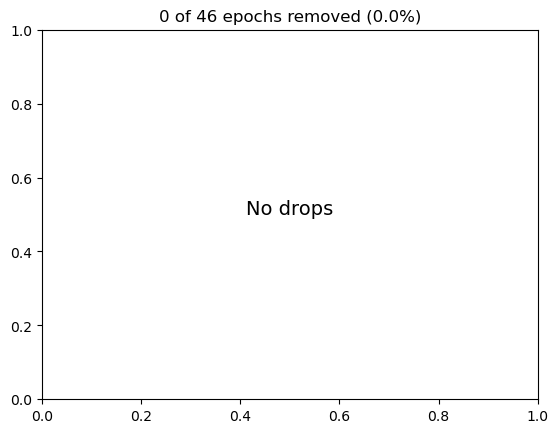

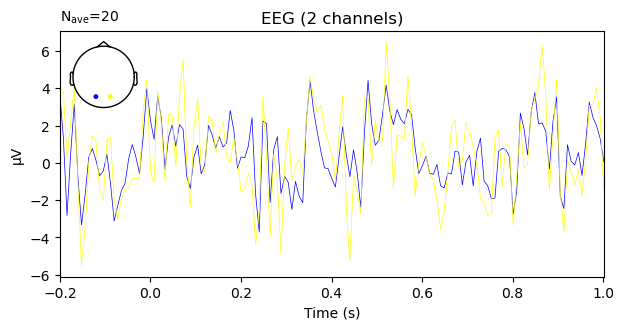

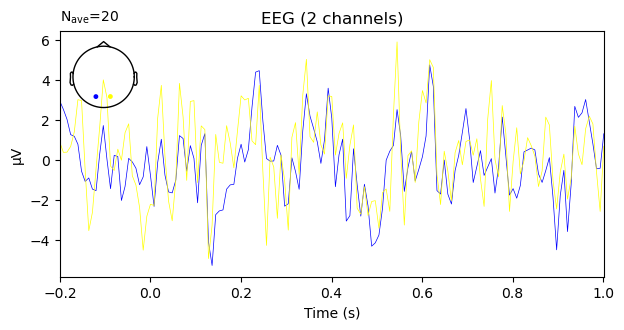


 SonyN 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.2003045892850311, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200305 - 1.00152 sec, baseline -0.200305 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


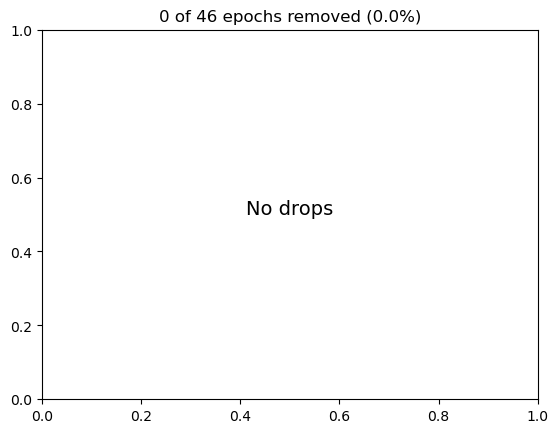

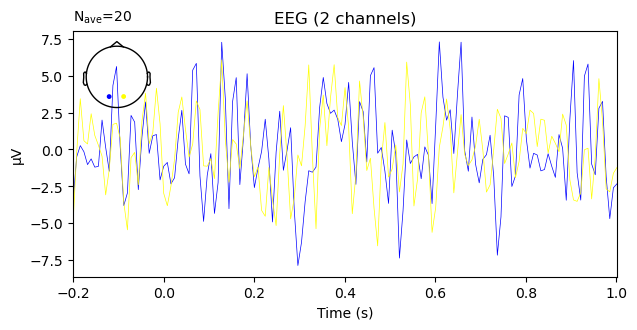

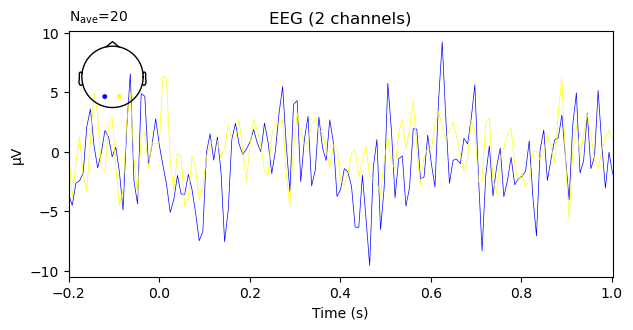


 Nasty 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20024467153565306, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200245 - 1.00122 sec, baseline -0.200245 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


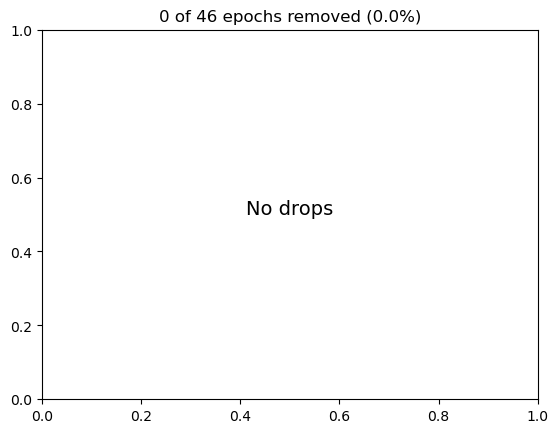

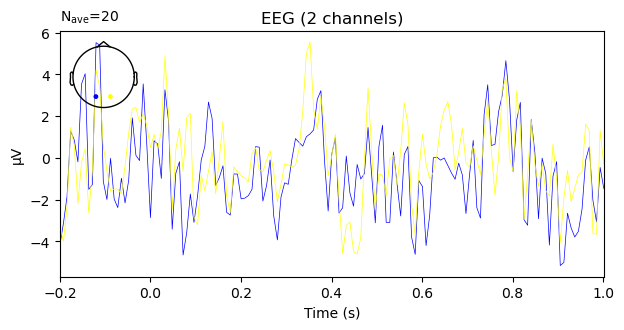

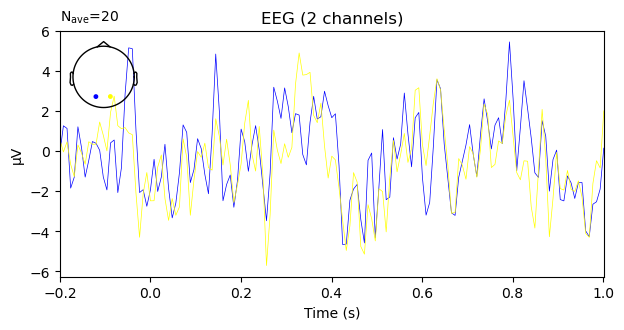


 Katya 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.2003585927601906, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200359 - 1.00179 sec, baseline -0.200359 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


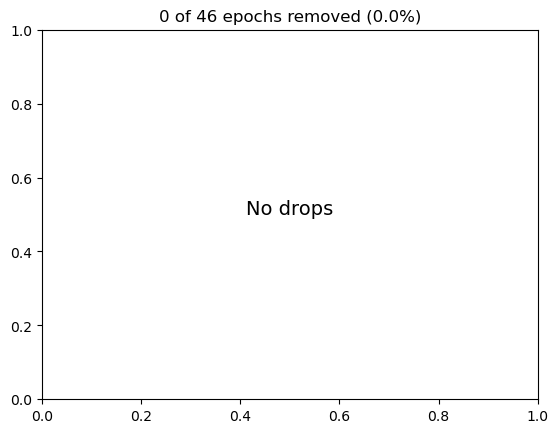

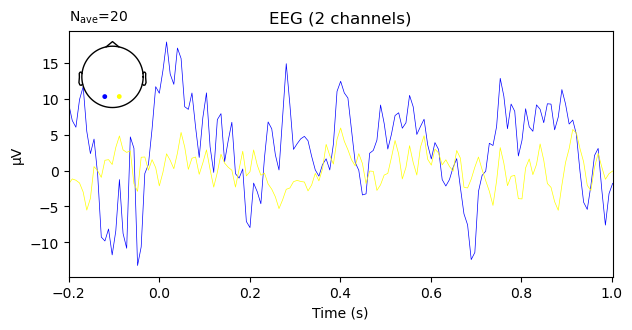

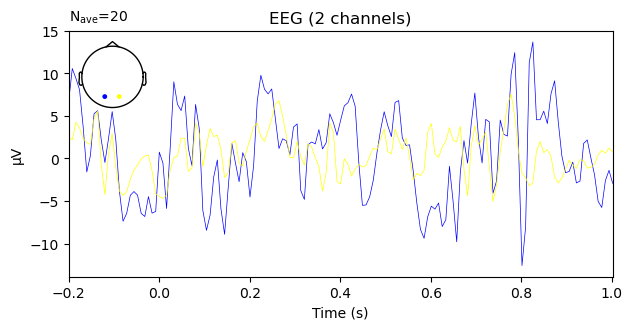


 Pilug 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20036300172606517, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200363 - 1.00182 sec, baseline -0.200363 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


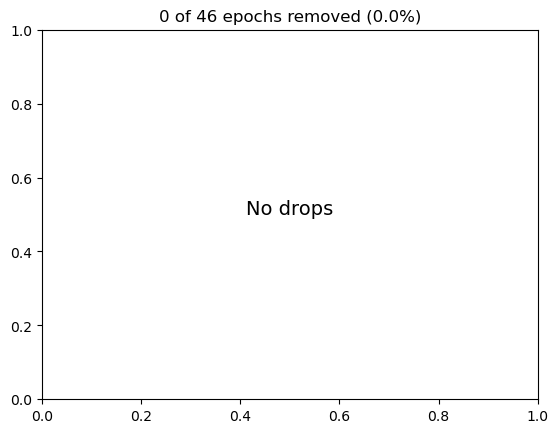

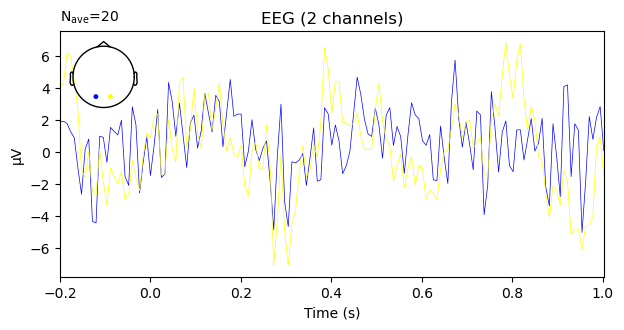

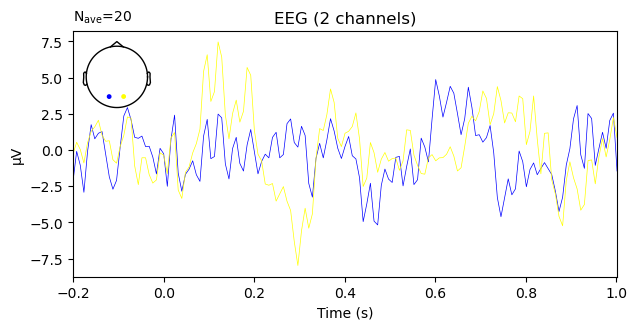


 Kurki 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20028365672209422, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200284 - 1.00142 sec, baseline -0.200284 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


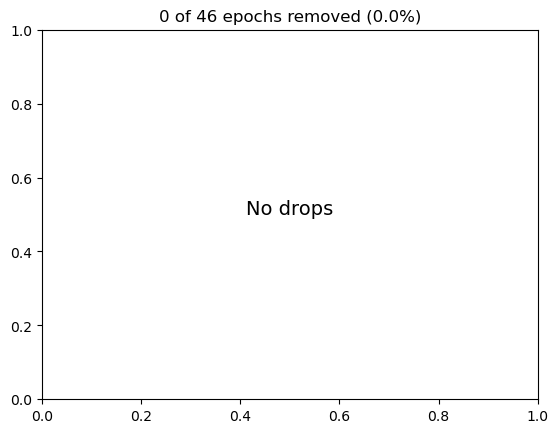

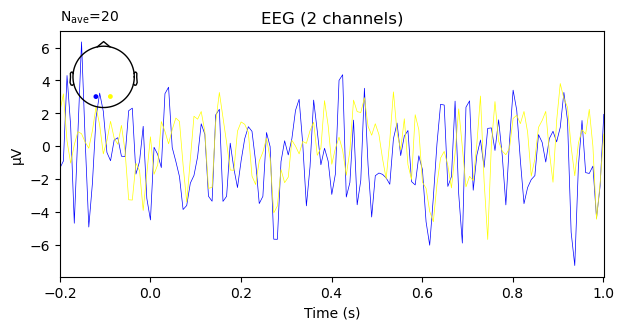

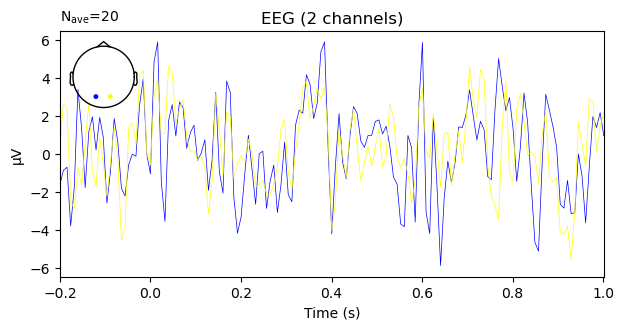


 Koblo 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20028833691371375, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200288 - 1.00144 sec, baseline -0.200288 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


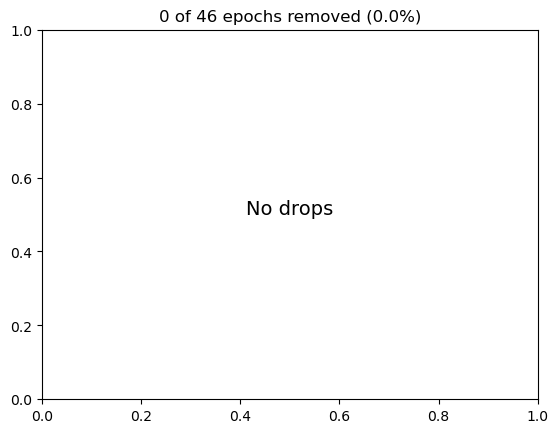

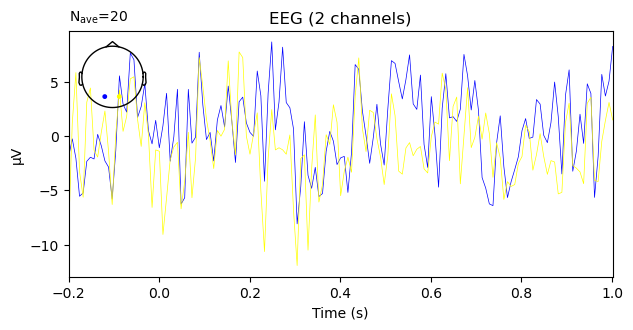

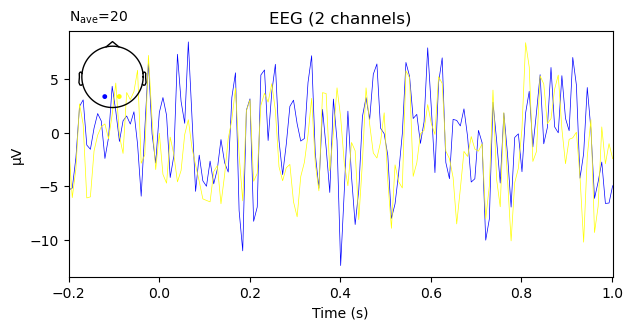


 Balts 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20007904449428662, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200079 - 1.0004 sec, baseline -0.200079 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


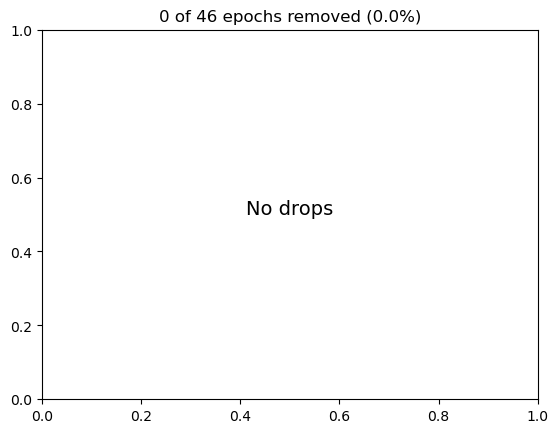

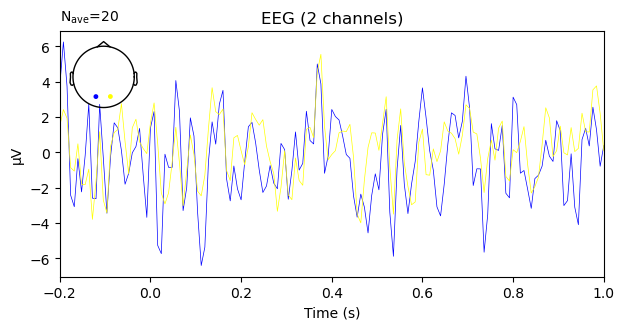

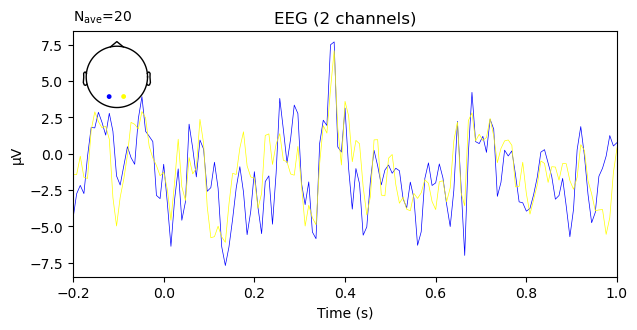


 Dolgi 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20023853636574024, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.200239 - 1.00119 sec, baseline -0.200239 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


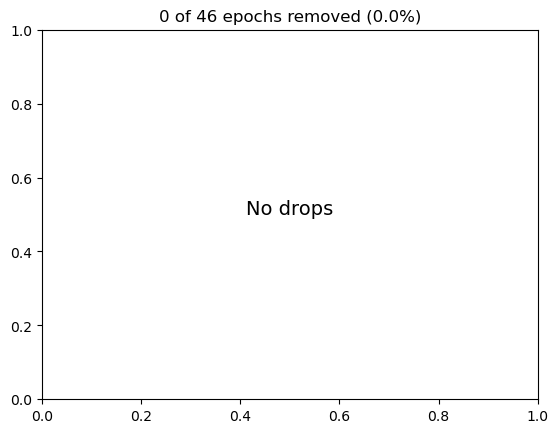

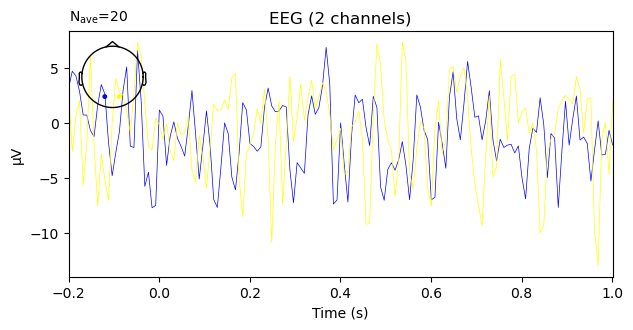

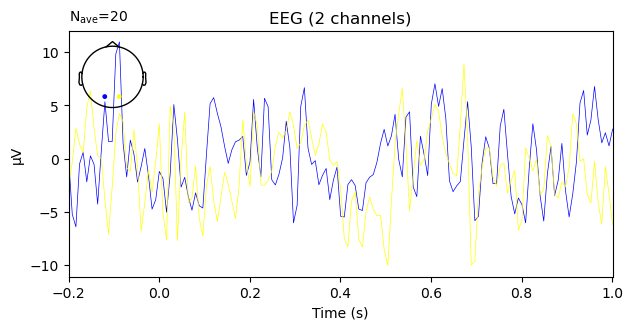


 Mosgo 

Not setting metadata
46 matching events found
Setting baseline interval to [-0.20017020918935088, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 151 original time points ...
0 bad epochs dropped
<Epochs |  46 events (all good), -0.20017 - 1.00085 sec, baseline -0.20017 – 0 sec, ~341 kB, data loaded,
 'blinking starts': 1
 'blinking ends': 1
 'EO start': 1
 'EO end': 1
 'EC start': 1
 'EC end': 1
 '1-back': 20
 '2-back': 20>


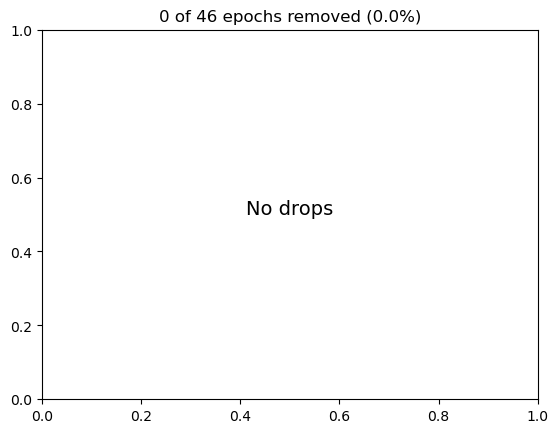

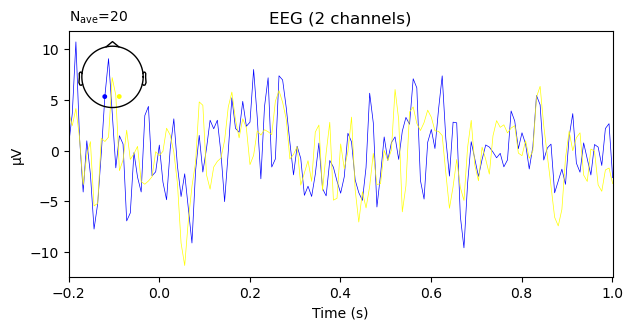

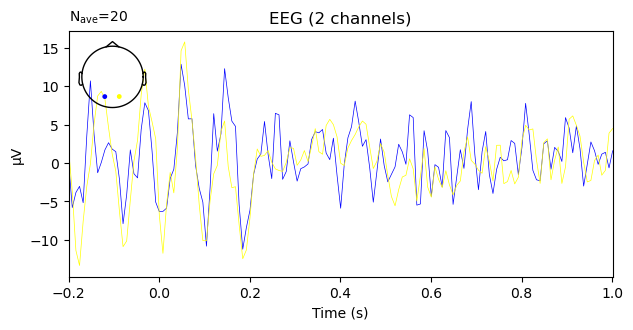

In [17]:
for i in names:
    print('\n', i, '\n')
    raw = raw_list[i]
    events = events_list[i]
    epo=mne.Epochs(raw,events, event_id=event_dict, tmin= -0.2, tmax=1, preload=True,picks=['O1','O2','F3','F4','T3','T4'],reject=None)
    epo.plot_drop_log()
    print(epo)
    oneb = epo['1-back'].average(picks=['O1','O2'])
    twob = epo['2-back'].average(picks=['O1','O2'])
    fig1 = oneb.plot()
    fig2 = twob.plot(spatial_colors=True)

## Считаем psd и колмогоров смирнов: закрытые глаза vs открытых 

In [6]:
%matplotlib inline


 Alice 

35.75118651789121 95.74494507647613
99.25278999019395 160.0394176046192
Effective window size : 2.050 (s)
Effective window size : 2.050 (s)
KstestResult(statistic=0.6875, pvalue=0.0006700468135385351)
0.00067
different

 Almaz 

59.22833316971831 119.22586547151089
124.87467159768126 185.857740287444
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
KstestResult(statistic=0.875, pvalue=1.6503616097008254e-06)
0.0
different

 Misha 

42.89398909872109 102.87348309894958
107.65550205169215 168.5962058916679
Effective window size : 2.051 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.051 (s)
KstestResult(statistic=0.5, pvalue=0.03499797755837617)
0.035
different

 Sasha 

29.99618673192916 90.01259560182268
92.63245485965943 153.58624456492575
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
KstestResult(statistic=0.9375, pvalue=1.0647494256134358e-07)
0.0
different

 SonyN 

30.766784914180775 90.73797894611909
95.06455807467576 156.06932378732483
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
KstestResult(statistic=0.5, pvalue=0.03499797755837617)
0.035
different

 Nasty 

45.6557851101289 105.68112784965626
111.06370462053462 171.88201625934317
Effective window size : 2.051 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.051 (s)
KstestResult(statistic=0.4375, pvalue=0.09332629866697198)
0.09333
equal

 Katya 

43.493843316382176 103.50524901991447
109.39579164706407 170.41700465810774
Effective window size : 2.052 (s)
Effective window size : 2.052 (s)
KstestResult(statistic=0.9375, pvalue=1.0647494256134358e-07)
0.0
different

 Pilug 

32.867546803143725 92.88027308013476
95.74145674478298 156.73996899026625
Effective window size : 2.052 (s)
Effective window size : 2.052 (s)
KstestResult(statistic=0.1875, pvalue=0.9522562797299043)
0.95226
equal

 Kurki 

61.046458568894316 121.03541943029597
123.82336793186752 184.77369034553524
Effective window size : 2.051 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.051 (s)
KstestResult(statistic=0.5625, pvalue=0.011199353883429802)
0.0112
different

 Koblo 

42.90176176691749 102.89212443931304
110.00636616648815 170.9581128560695
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
KstestResult(statistic=0.9375, pvalue=1.0647494256134358e-07)
0.0
different

 Balts 

27.226756374782525 87.29848869374715
91.38010120143059 152.3161749926105
Effective window size : 2.049 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.049 (s)
KstestResult(statistic=0.5, pvalue=0.03499797755837617)
0.035
different

 Dolgi 

38.421770357858236 98.37318814576086
105.41357508438028 166.39822371993014
Effective window size : 2.050 (s)
Effective window size : 2.050 (s)
KstestResult(statistic=0.75, pvalue=0.00011965121670330985)
0.00012
different

 Mosgo 

28.296060771006644 88.2270214022983
91.44575836606306 152.50567897718267
Effective window size : 2.050 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.050 (s)
KstestResult(statistic=0.75, pvalue=0.00011965121670330985)
0.00012
different
total number of different: 11
total number of equal: 2


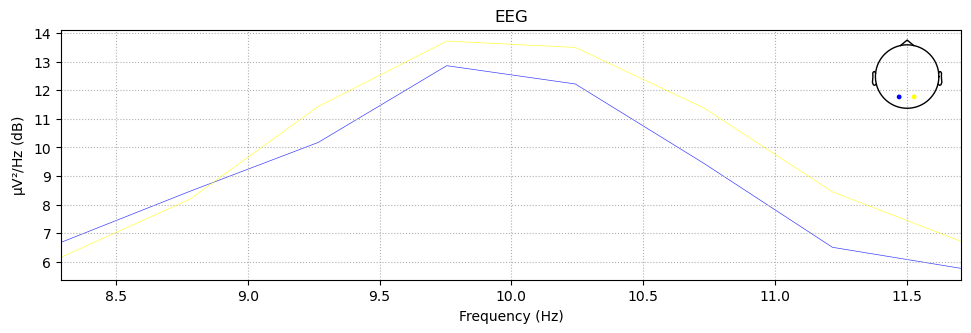

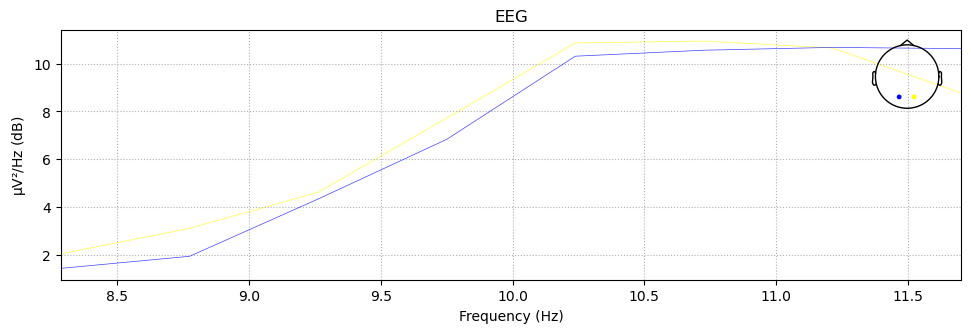

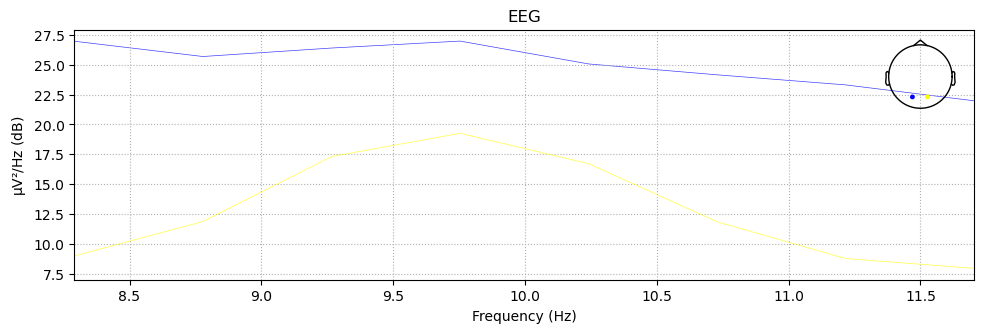

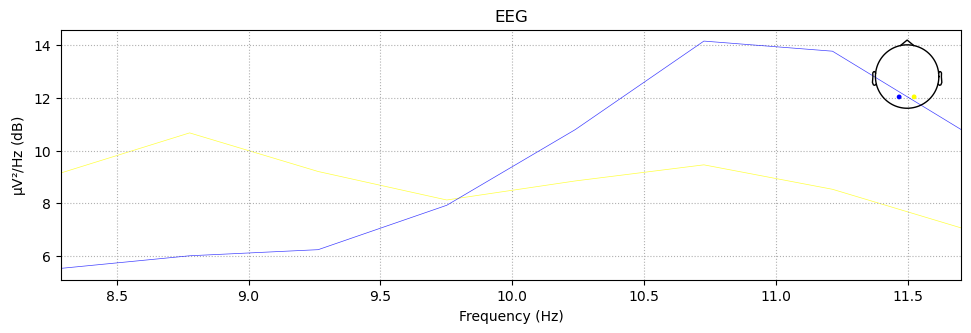

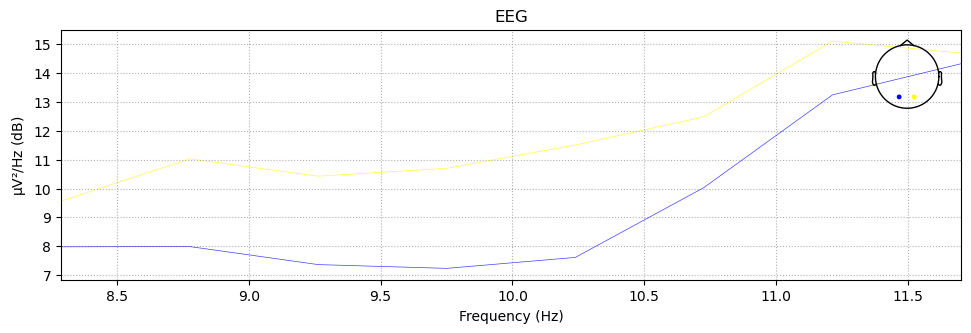

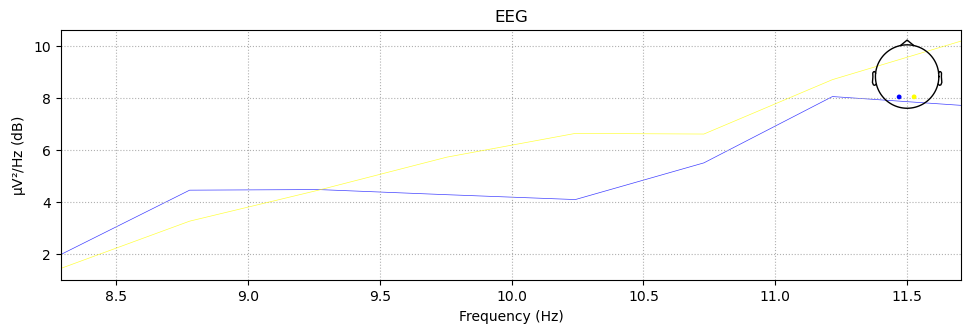

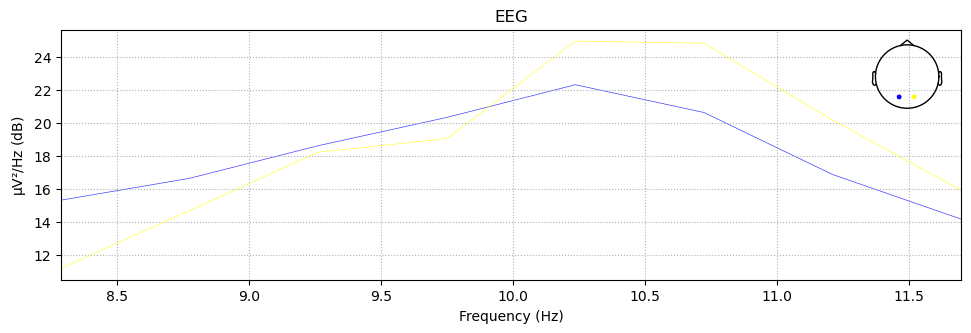

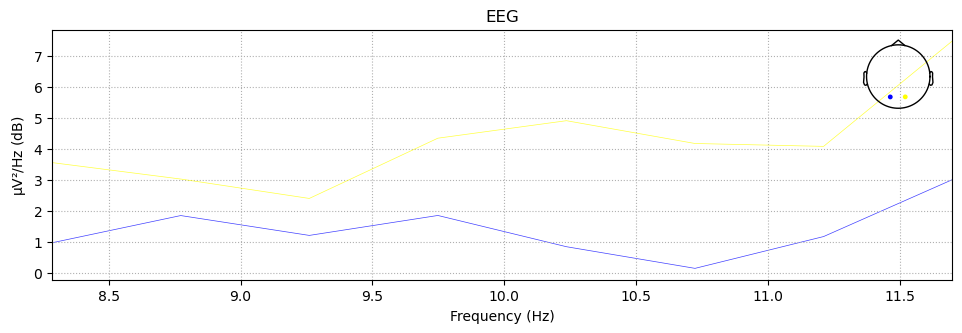

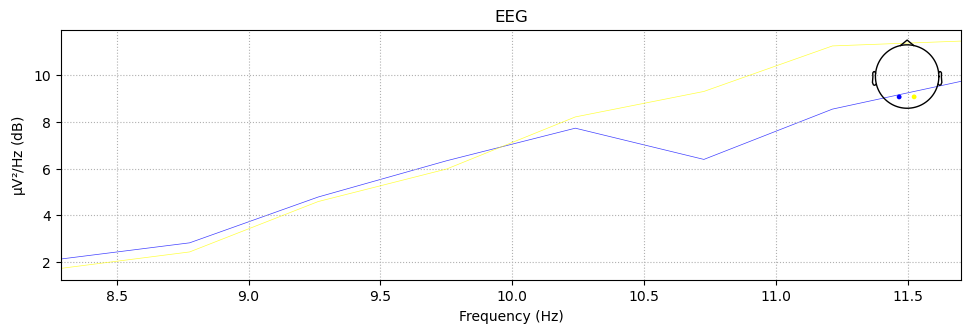

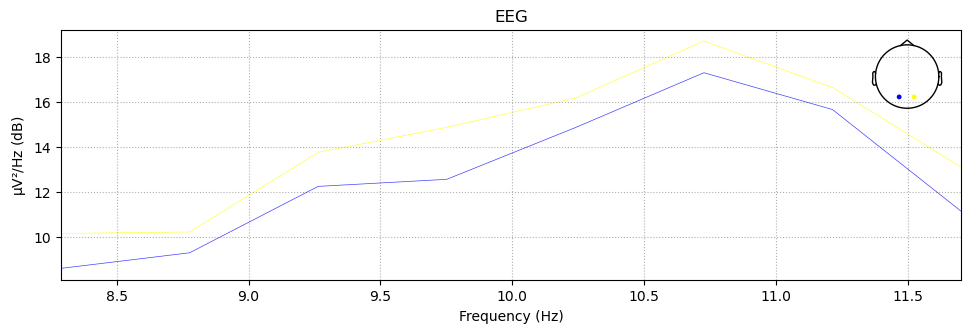

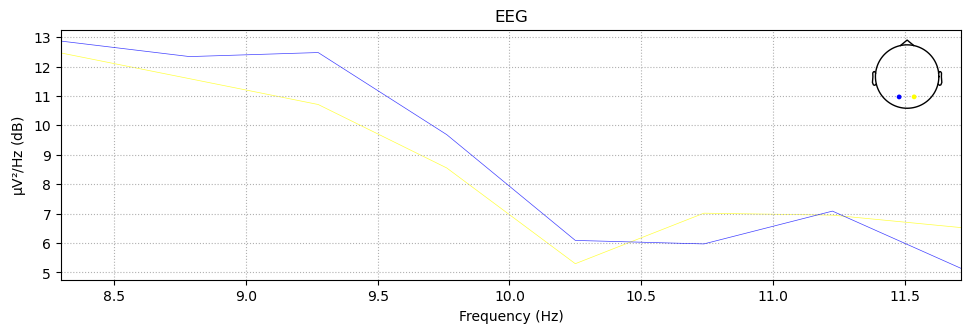

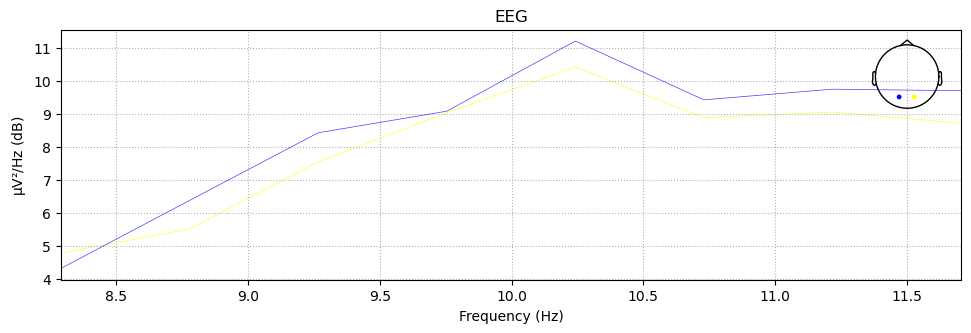

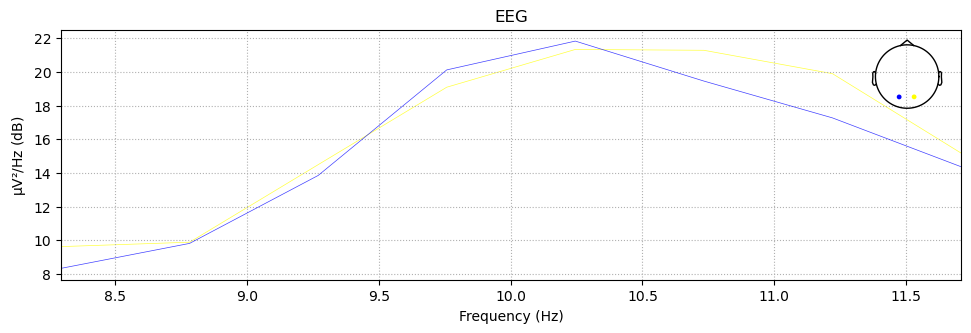

In [8]:
diff = 0
equa = 0
for i in names:
    print('\n', i, '\n')
    raw = raw_list[i]
    events = events_list[i]
    if events[3][2] == 3:
        eot1 = events[3][0] / raw.info['sfreq']
        eot2 = events[4][0] / raw.info['sfreq']
        print(eot1,eot2)
        raw_eo = raw.copy().crop(tmin=eot1, tmax=eot2)
    if events[5][2] == 4:
        ect1 = events[5][0] / raw.info['sfreq']
        ect2 = events[6][0] / raw.info['sfreq']
        print(ect1,ect2)
        raw_ec = raw.copy().crop(tmin=ect1, tmax=ect2)
    #raw_ec.plot(events=events)
    #raw_eo.plot(events=events)
    psd_ecl = raw_ec.compute_psd(picks=['O1','O2'],fmin=8,fmax=12)
    psd_ecl.plot()
    psd_ecl_lil = np.concatenate([psd_ecl._data[0], psd_ecl._data[1]])
    psd_eol = raw_eo.compute_psd(picks=['O1','O2'],fmin=8,fmax=12)
    psd_eol_lil = np.concatenate([psd_eol._data[0], psd_eol._data[1]])
    ans1 = str(scipy.stats.kstest(psd_ecl_lil, psd_eol_lil))
    nbeg = ans1.rfind('e=')
    print(ans1)
    ans1 = ans1.replace("e", "E" )
    nbeg += 2
    nend = len(ans1) - 1
    p = float(ans1[nbeg:nend])
    p = round(p, 5)
    if p < 0.05:
        ans = 'different'
        diff += 1
    else:
        ans = 'equal'
        equa += 1
    print(p,ans,sep='\n')
print('total number of different:', diff)
print('total number of equal:', equa)

### permutation test

In [15]:
from mlxtend.evaluate import permutation_test

In [ ]:


p_value = permutation_test(psd_ecl_lil, psd_eol_lil,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
print(p_value)

In [ ]:
diff = 0
equa = 0
for i in names:
    print('\n', i, '\n')
    raw = raw_list[i]
    events = events_list[i]
    if events[3][2] == 3:
        eot1 = events[3][0] / raw.info['sfreq']
        eot2 = events[4][0] / raw.info['sfreq']
        print(eot1,eot2)
        raw_eo = raw.copy().crop(tmin=eot1, tmax=eot2)
    if events[5][2] == 4:
        ect1 = events[5][0] / raw.info['sfreq']
        ect2 = events[6][0] / raw.info['sfreq']
        print(ect1,ect2)
        raw_ec = raw.copy().crop(tmin=ect1, tmax=ect2)
    #raw_ec.plot(events=events)
    #raw_eo.plot(events=events)
    psd_ecl = raw_ec.compute_psd(picks=['O1','O2'],fmin=8,fmax=12)
    psd_ecl.plot()
    psd_ecl_lil = np.concatenate([psd_ecl._data[0], psd_ecl._data[1]])
    psd_eol = raw_eo.compute_psd(picks=['O1','O2'],fmin=8,fmax=12)
    psd_eol_lil = np.concatenate([psd_eol._data[0], psd_eol._data[1]])
    p = permutation_test(psd_ecl_lil, psd_eol_lil)
    if p < 0.05:
        ans = 'different'
        diff += 1
    else:
        ans = 'equal'
        equa += 1
    print(p,ans,sep='\n')
print('total number of different:', diff)
print('total number of equal:', equa)


 Alice 

35.75118651789121 95.74494507647613
99.25278999019395 160.0394176046192
Effective window size : 2.050 (s)
Effective window size : 2.050 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


#### psd plot

In [9]:
%matplotlib inline


 Alice 

35.75118651789121 95.74494507647613
99.25278999019395 160.0394176046192
Effective window size : 2.050 (s)
Effective window size : 2.050 (s)
eyes open
eyes closed


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)



 Almaz 

59.22833316971831 119.22586547151089
124.87467159768126 185.857740287444
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
eyes open
eyes closed


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)



 Misha 

42.89398909872109 102.87348309894958
107.65550205169215 168.5962058916679
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
eyes open
eyes closed


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)



 Sasha 

29.99618673192916 90.01259560182268
92.63245485965943 153.58624456492575
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
eyes open
eyes closed


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)



 SonyN 

30.766784914180775 90.73797894611909
95.06455807467576 156.06932378732483
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
eyes open


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


eyes closed

 Nasty 

45.6557851101289 105.68112784965626
111.06370462053462 171.88201625934317
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
eyes open
eyes closed


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)



 Katya 

43.493843316382176 103.50524901991447
109.39579164706407 170.41700465810774
Effective window size : 2.052 (s)
Effective window size : 2.052 (s)
eyes open


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


eyes closed

 Pilug 

32.867546803143725 92.88027308013476
95.74145674478298 156.73996899026625
Effective window size : 2.052 (s)
Effective window size : 2.052 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


eyes open
eyes closed

 Kurki 

61.046458568894316 121.03541943029597
123.82336793186752 184.77369034553524
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


eyes open


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


eyes closed

 Koblo 

42.90176176691749 102.89212443931304
110.00636616648815 170.9581128560695
Effective window size : 2.051 (s)
Effective window size : 2.051 (s)
eyes open
eyes closed


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)



 Balts 

27.226756374782525 87.29848869374715
91.38010120143059 152.3161749926105
Effective window size : 2.049 (s)
Effective window size : 2.049 (s)
eyes open
eyes closed


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\_mpl_figure.py:2083: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(FigureClass=FigureClass, **kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)



 Dolgi 

38.421770357858236 98.37318814576086
105.41357508438028 166.39822371993014
Effective window size : 2.050 (s)
Effective window size : 2.050 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


eyes open
eyes closed

 Mosgo 

28.296060771006644 88.2270214022983
91.44575836606306 152.50567897718267
Effective window size : 2.050 (s)
Effective window size : 2.050 (s)


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


eyes open


C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\Lenovo\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


eyes closed


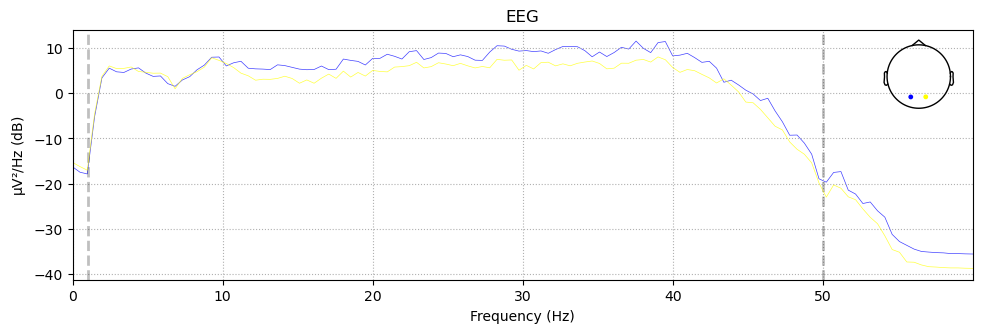

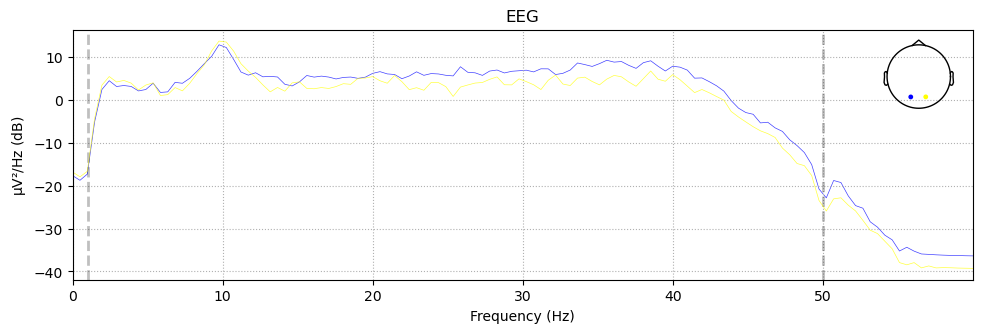

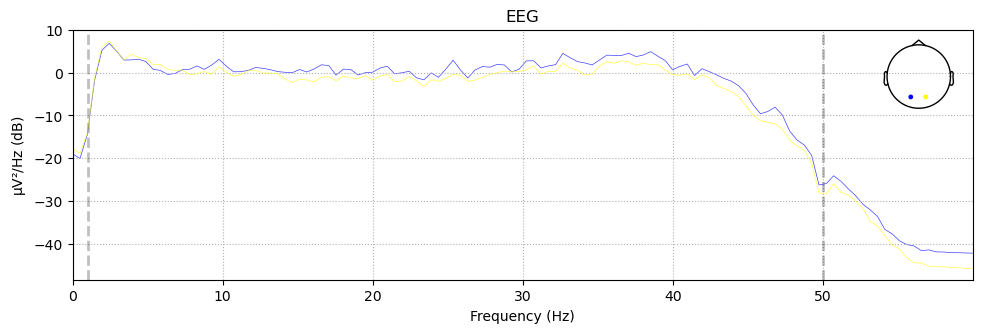

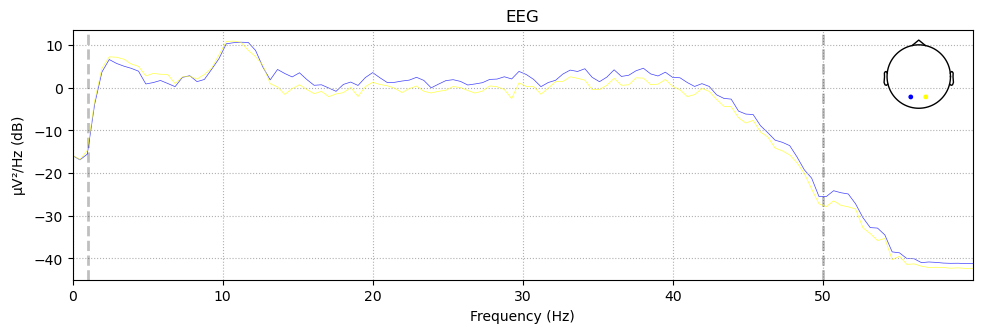

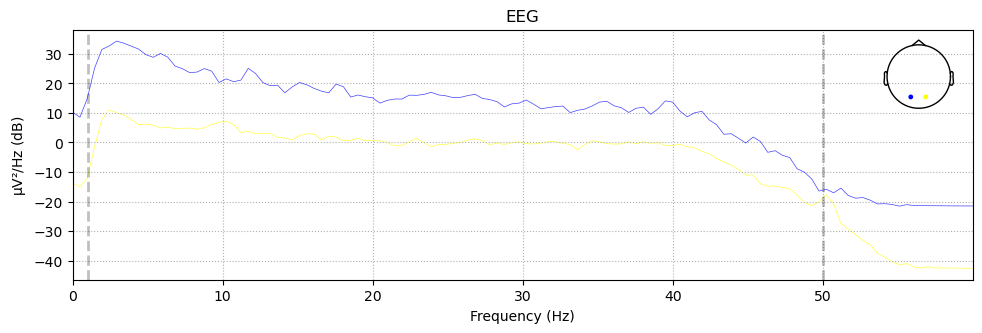

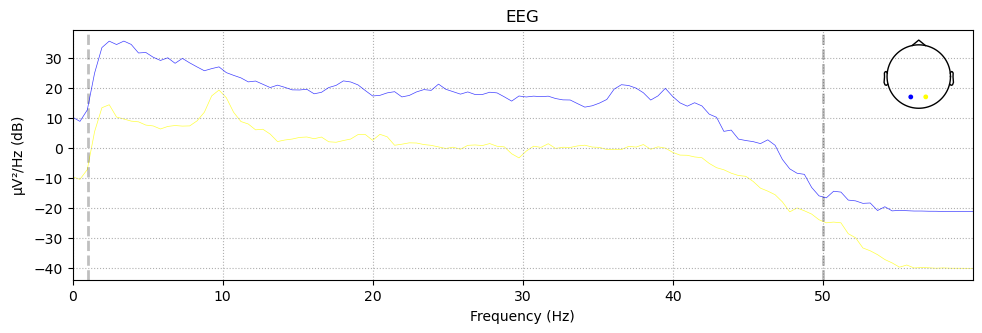

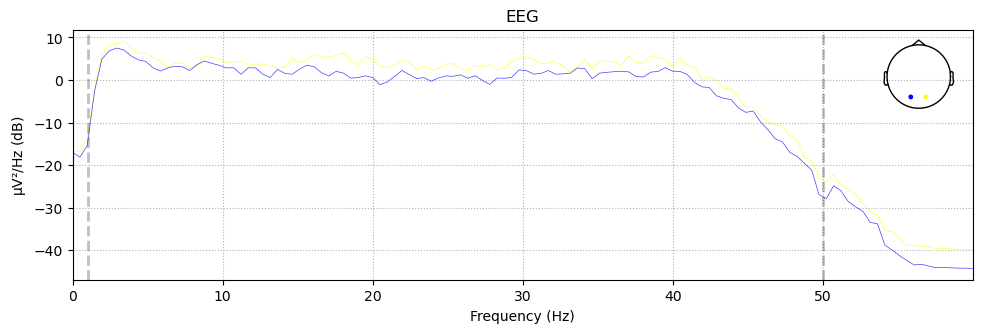

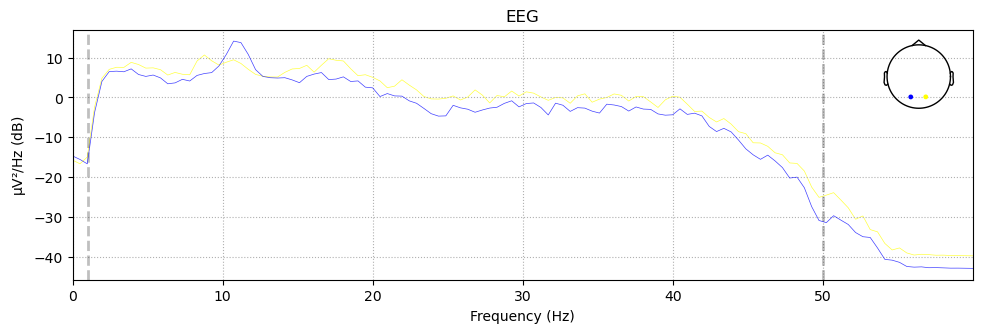

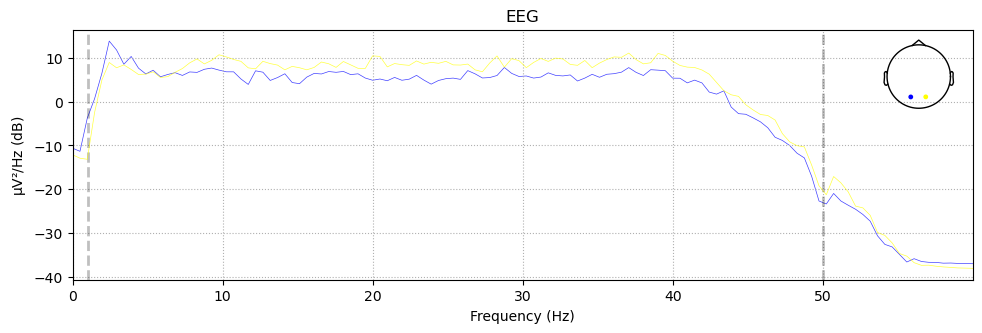

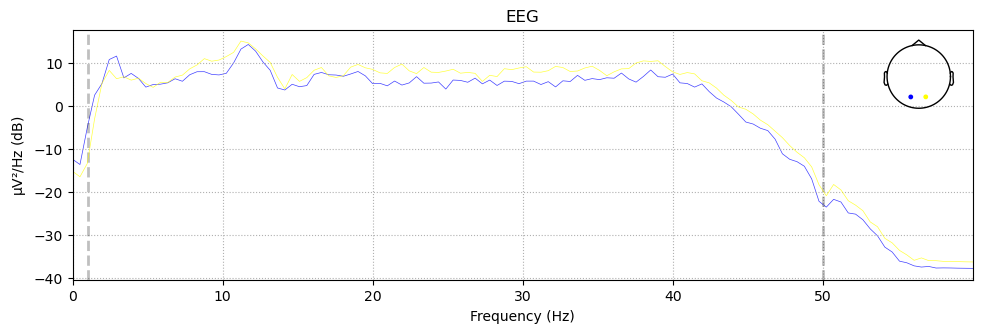

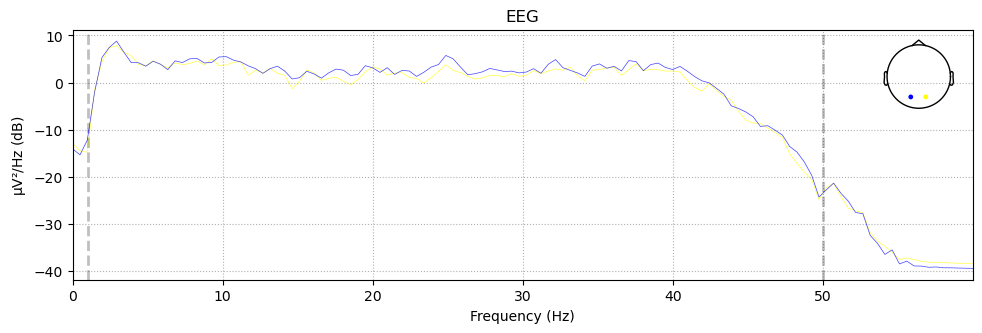

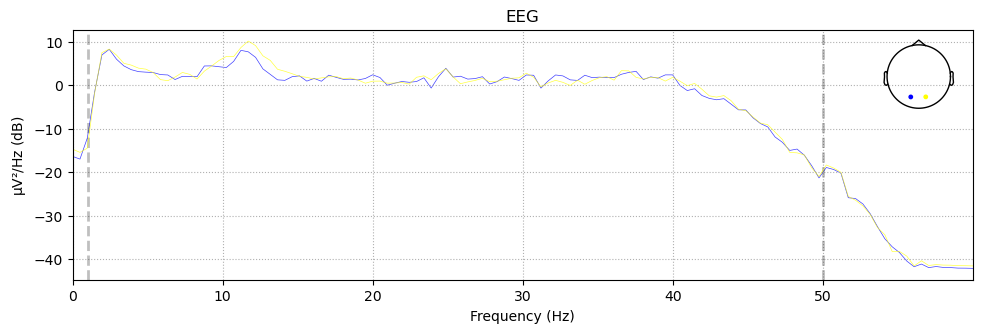

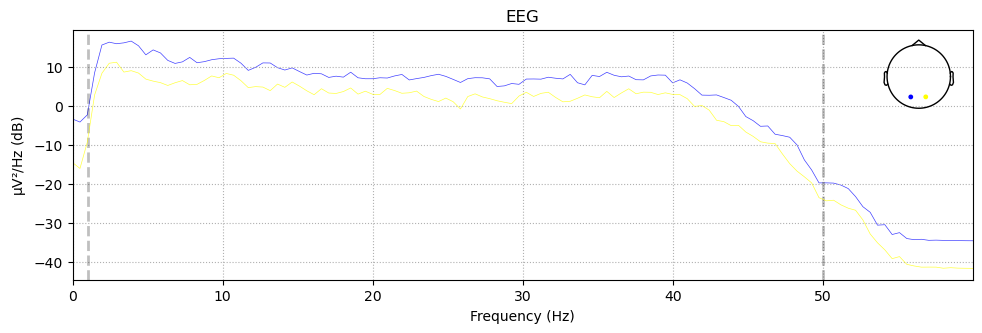

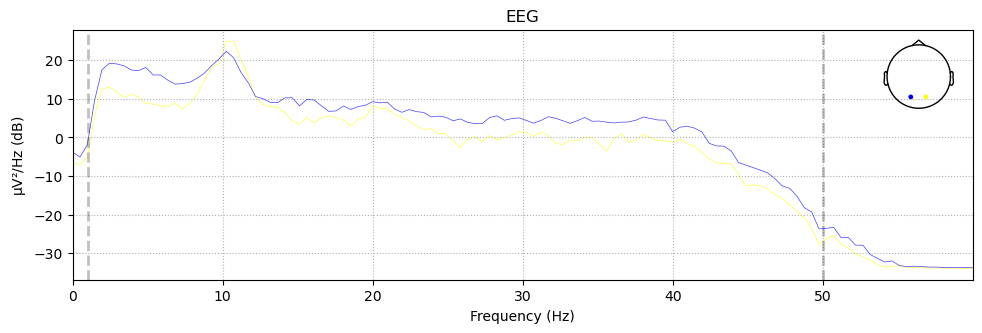

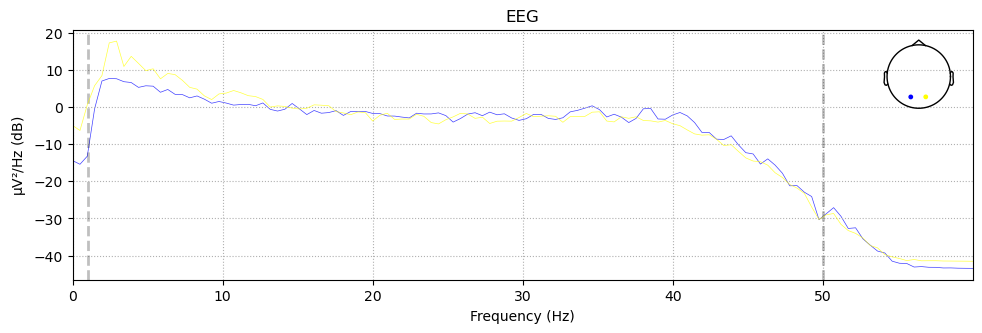

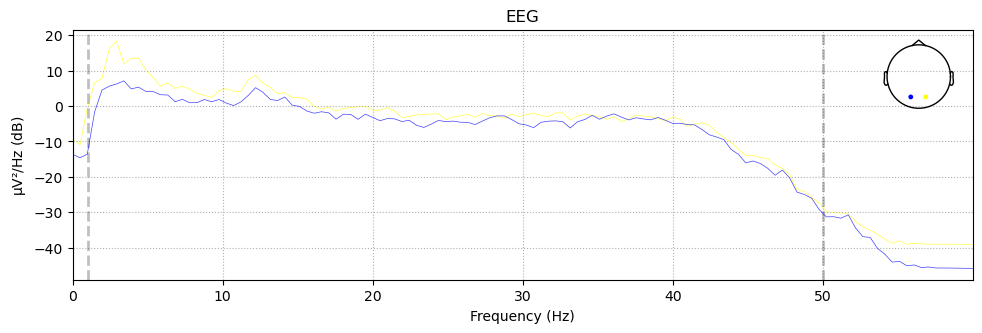

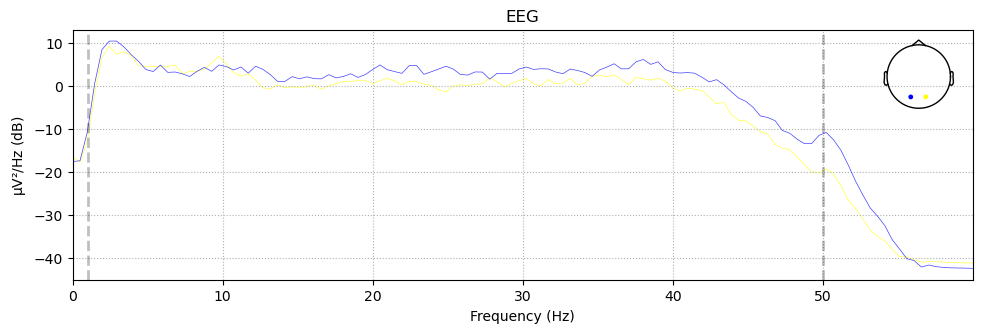

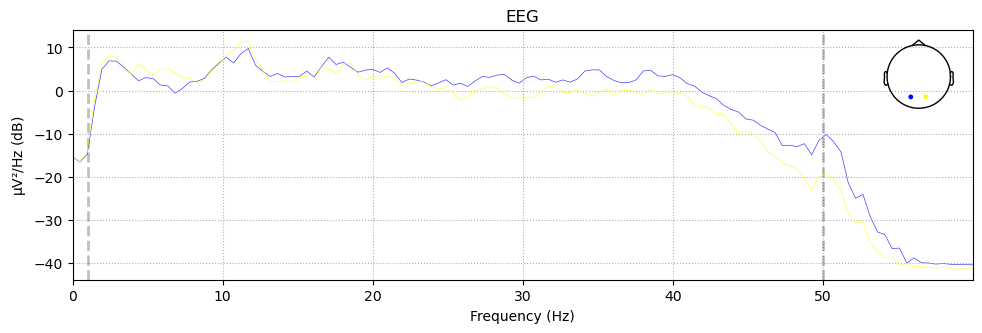

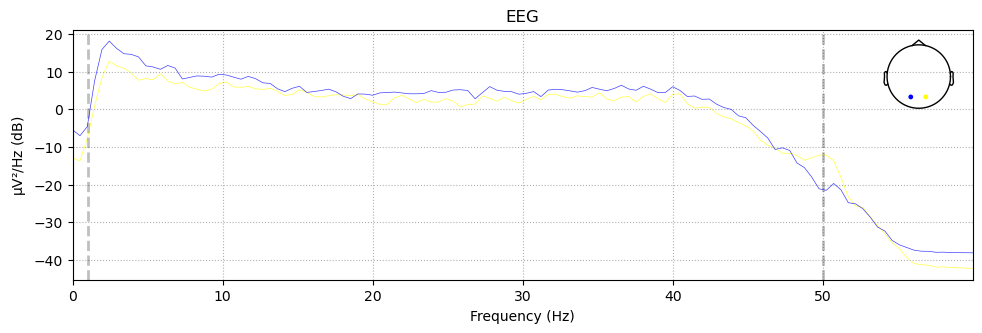

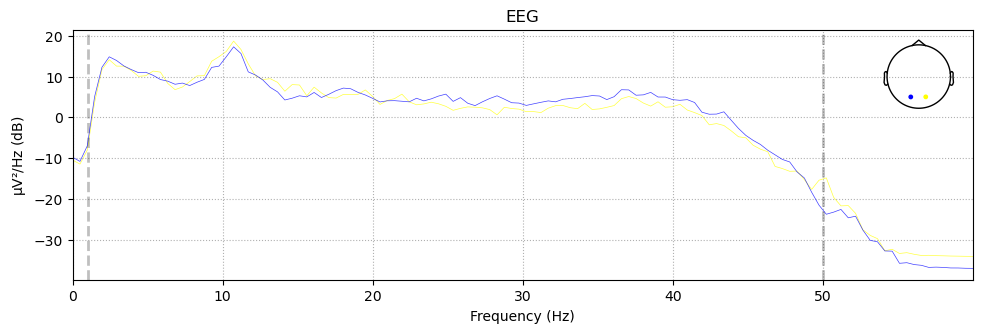

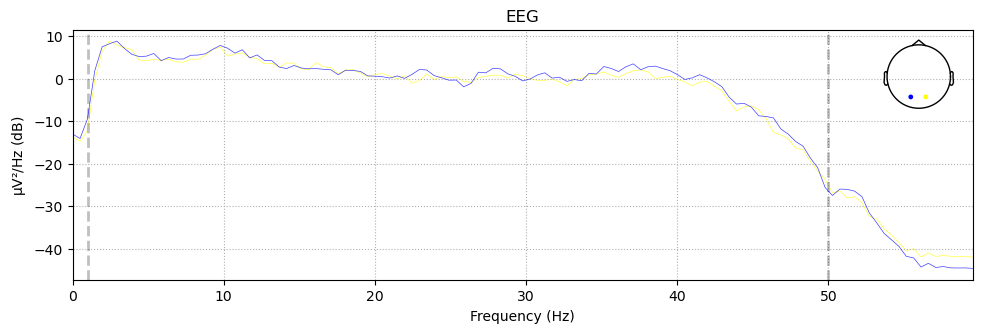

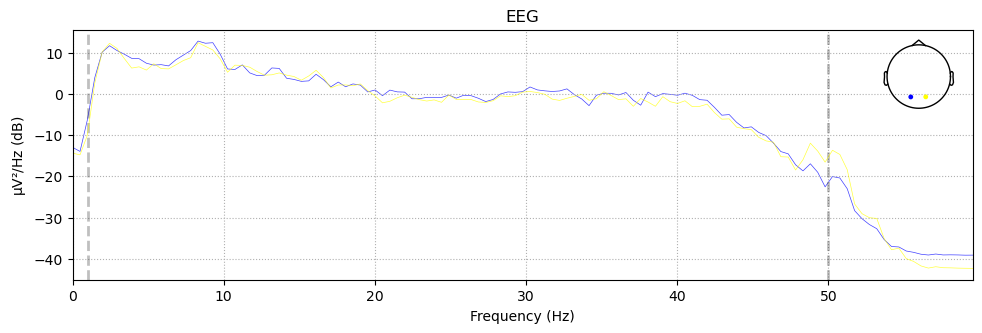

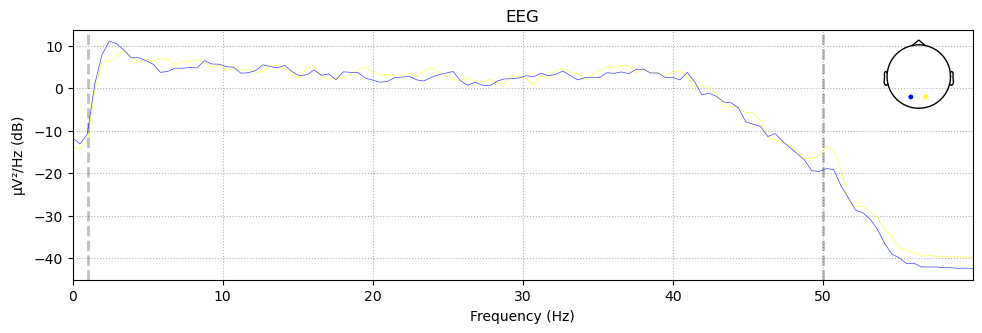

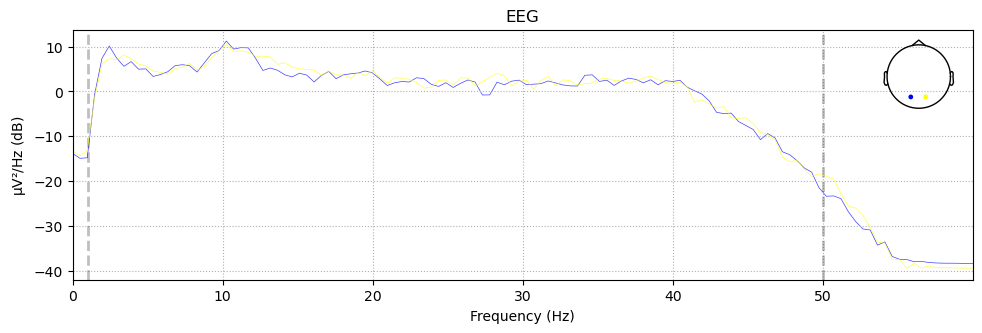

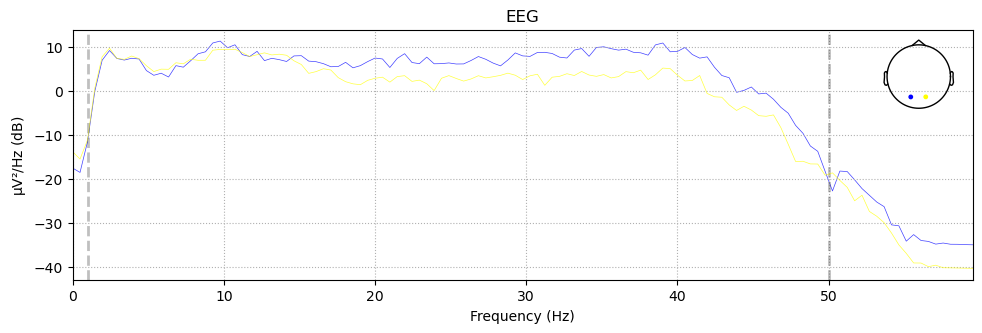

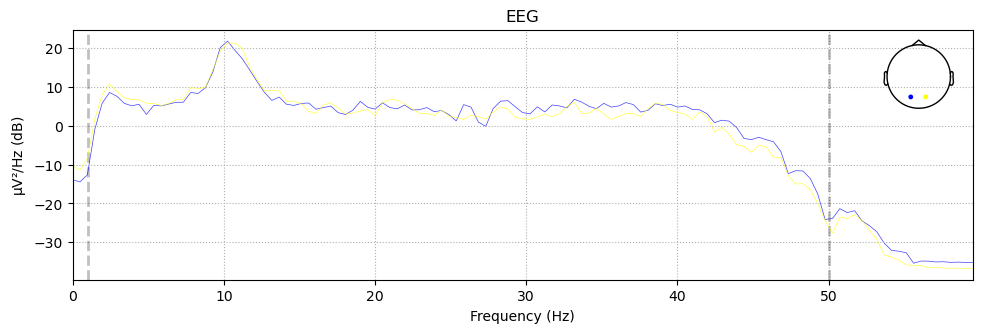

In [13]:
diff = 0
equa = 0
for i in names:
    print('\n', i, '\n')
    raw = raw_list[i]
    events = events_list[i]
    if events[3][2] == 3:
        eot1 = events[3][0] / raw.info['sfreq']
        eot2 = events[4][0] / raw.info['sfreq']
        print(eot1,eot2)
        raw_eo = raw.copy().crop(tmin=eot1, tmax=eot2)
    if events[5][2] == 4:
        ect1 = events[5][0] / raw.info['sfreq']
        ect2 = events[6][0] / raw.info['sfreq']
        print(ect1,ect2)
        raw_ec = raw.copy().crop(tmin=ect1, tmax=ect2)
    #raw_ec.plot(events=events)
    #raw_eo.plot(events=events)
    psd_ecl = raw_ec.compute_psd(picks=['O1','O2'], fmin=0, fmax=60)
    psd_eol = raw_eo.compute_psd(picks=['O1','O2'], fmin=0, fmax=60)
    print('eyes open')
    psd_eol.plot()
    plt.savefig('C:\\Users\\Lenovo\\1easyEEG\\psd\\' + i + 'EO.png')
    print('eyes closed')
    psd_ecl.plot()
    plt.savefig('C:\\Users\\Lenovo\\1easyEEG\\psd\\' + i + 'EC.png')